# Python for Finance Report #

SSquared

Dang Huy Bui 126124173

Patrick Guth 156324064


In [1]:
import pandas as pd
import os
import wrds
import math
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas_datareader.data as web
from pathlib import Path
from IPython.display import display, Markdown


In [2]:
from typing import TypeAlias, Literal
from pandas import DataFrame, Timestamp
import statsmodels.formula.api as smf

In [23]:
db = wrds.Connection(wrds_username='sdbui')

Loading library list...
Done


In [24]:
db.describe_table('crsp_a_stock','dsf_v2') #, 'msf_v2')

Approximately 107691622 rows in crsp_a_stock.dsf_v2.


,name,nullable,type,comment
0,permno,True,INTEGER,PERMNO
1,hdrcusip,True,VARCHAR(8),Header CUSIP -8 Characters
2,permco,True,INTEGER,PERMCO
3,siccd,True,INTEGER,Sic Code
4,nasdissuno,True,INTEGER,Nasdaq Issue Number
5,yyyymmdd,True,INTEGER,YYYYMMDD - Daily Calendar Period Key
6,sharetype,True,VARCHAR(3),Share Type
7,securitytype,True,VARCHAR(4),Security Type
8,securitysubtype,True,VARCHAR(3),Security Sub-Type
9,usincflg,True,VARCHAR(1),US Incorporation Flag


## Executive Summary ##

We would like to search for more empirical evidence that the covered call writing strategy can contribute to portfolio outperformance to a fixed benchmark like the S&P 500 or XYLD ETF. Here we can also distinguish between selling index options or selling stock options inside the index.

### Covered Call Strategy ###

The covered call writing strategy (CCW) got popular in the year 2002 when the Chicago Board Options Exchange (CBOE) introduced the S&P500 BuyWrite index. The index is based on the performance of the S&P500 and the collected premium of selling S&P500 index options. Nowadays CCW is a widely used strategy to enhance portfolio returns during quiet market conditions. The strategy contains a long position in an underlying stock or index and  a short call of the respective stock or index. It is noteworthy to say that the sold calls should match the position of the underlying, meaning that one option contract exists of 100 options where each option is referring to 1 amount of stock, so 100 stocks respectively. When the call gets exercised then the stocks have to be delivered to a fixed price. So the difference between the strike price and the spot price is the loss, the option premium received makes the loss a bit smaller. If the call is not exercised, then the premium received will enhance the stock return and therefore the portfolio.

## Data ##

MAG7: Apple, Microsoft, Nvidia, Amazon, Berkshire Hathaway, Eli Lilly, Walmart, based on historic market data and actual market capitalization and all of them are constituents of the S&P 500
- Stock data from crsp
- Option data from optionmetrics

Some of the stocks we had to adjust for stock splits, for that reason we extracted the dlycumfacpr_current from CRSP, we also had to adjust the strike of the options to the factor and divide the strike prices by 1000. The option data contains only options expiring every third Friday of month.

In [ ]:
## Get stock data from crsp

start_year = 2000
end_year = 2022
permno_list = [17778, 10107, 14593, 84788, 86580, 55976, 50876]

dfs = []  # List to store data for each year

for year in range(start_year, end_year + 1):
    stock_query = f"""
        SELECT permno, yyyymmdd, ticker, dlyprc, dlyret, dlycaldt, shrout, dlyfacprc, dlycumfacpr
        FROM crsp_a_stock.dsf_v2
        WHERE yyyymmdd >= {year}0101 AND yyyymmdd <= {year}1231
        AND permno IN ({','.join(map(str, permno_list))})
    """
    # GET dlycumfacpr to get the price adjustment when stock split and stock dividend
    df = db.raw_sql(stock_query)

    if not df.empty:
        #df["Year"] = year  # Add a column to distinguish years
        dfs.append(df)

# Combine all data
final_df = pd.concat(dfs, ignore_index=True)

# Ensure tickers are properly assigned
ticker_mapping = final_df.groupby("permno")["ticker"].first().to_dict()

#get log returns
final_df['log_return'] = final_df['dlyret'].apply(lambda x: math.log(x + 1))

# Dictionary to store data grouped by permno
stock_dict = {permno: group for permno, group in final_df.groupby('permno')}

# Save each stock's data in a separate CSV file with ticker names
for permno, stock_df in stock_dict.items():
    ticker = ticker_mapping.get(permno, f"stock_{permno}")  # Default to permno if no ticker
    file_name = f"{ticker}.csv"  # Name file using ticker symbol
    stock_df.to_csv(file_name, index=False)

#print("CSV files successfully created with stock names!")



In [6]:
## Get option data from optionmetrics

start_year = 2000
end_year = 2022
secid_list = [102108, 107525, 101594, 101310, 108321, 111860, 106967]

ticker_dict = {
        102108: 'BRK',
        107525: 'MSFT',
        101594: 'AAPL',
        101310: 'AMZN',
        108321: 'NVDA',
        111860: 'WMT',
        106967: 'LLY'}

dfo = []  # List to store data for each year

for year in range(start_year, end_year + 1):
    option_query = f"""
        SELECT secid, impl_volatility, date, best_bid, strike_price, exdate, expiry_indicator, cp_flag
        FROM optionm.opprcd{year}
        WHERE date >= '{year}-01-01' AND date <= '{year}-12-31' AND
            secid IN ({','.join(map(str, secid_list))}) AND
            cp_flag = 'C' AND
            expiry_indicator IS NULL
    """

# expiry_indicator empty cell means that the option will expire the 3rd friday of a month

    df = db.raw_sql(option_query)

    if not df.empty:
        dfo.append(df)

# Combine all data
option_df = pd.concat(dfo, ignore_index=True)

# Map secid to ticker
#option_df["ticker"] = option_df["secid"].map(ticker_dict)

# Dictionary to store data grouped by permno
option_dict = {secid: group for secid, group in option_df.groupby('secid')}

# Save each stock's data in a separate CSV file with ticker names
for secid, option_df in option_dict.items():
    ticker = ticker_dict.get(secid, f"{secid}")  # Default to permno if no ticker
    file_name = f"{ticker}_options.csv"  # Name file using ticker symbol
    option_df.to_csv(file_name, index=False)

print("CSV files successfully created with option names!")


CSV files successfully created with option names!


In [26]:
db.close()

In [15]:
## Sort option data, to get only monthly option durations

tickers = ['BRK', 'MSFT', 'AAPL', 'AMZN', 'NVDA', 'WMT', 'LLY']

for ticker in tickers:
    file_name = f"{ticker}_options.csv"

    if not os.path.exists(file_name):
        print(f"File {file_name} not found. Skipping.")
        continue

    option_df = pd.read_csv(file_name)
    option_df['date'] = pd.to_datetime(option_df['date'])
    option_df['exdate'] = pd.to_datetime(option_df['exdate'])

    option_df = option_df.sort_values('exdate').reset_index(drop=True)
    filtered_rows = []

    unique_exdates = np.sort(option_df['exdate'].unique().copy())
    unique_dates= np.sort(option_df['date'].unique().copy())

    for i in range(1, len(unique_exdates)):
        prev_exdate = unique_exdates[i - 1]
        target_date = prev_exdate - pd.Timedelta(days=1)
        if target_date not in unique_dates:
            # Find the nearest valid date <= target_date
            date_position = unique_dates <= target_date
            valid_dates = unique_dates[date_position]
            target_date = valid_dates[-1]  # Last valid date <= target_date
        current_exdate = unique_exdates[i]

        candidates = option_df[
            (option_df['date'] == target_date) &
            (option_df['exdate'] == current_exdate)
        ]

        if not candidates.empty:
            filtered_rows.append(candidates)
        else:
            print(f"{ticker}: No data for exdate {str(current_exdate)} on target date {str(target_date)}")

    if filtered_rows:
        filtered_df = pd.concat(filtered_rows, ignore_index=True)
        output_file = f"{ticker}_filtered_options.csv"
        filtered_df.to_csv(output_file, index=False)
        print(f"{ticker}: Filtered data saved to {output_file}")
    else:
        print(f"{ticker}: No matching rows found.")


BRK: No data for exdate 2014-09-22T00:00:00.000000000 on target date 2014-09-19 00:00:00
BRK: Filtered data saved to BRK_filtered_options.csv
MSFT: Filtered data saved to MSFT_filtered_options.csv
AAPL: Filtered data saved to AAPL_filtered_options.csv
AMZN: Filtered data saved to AMZN_filtered_options.csv
NVDA: Filtered data saved to NVDA_filtered_options.csv
WMT: Filtered data saved to WMT_filtered_options.csv
LLY: Filtered data saved to LLY_filtered_options.csv


In [53]:
## Merge data stock data and option data

# List of stock tickers
tickers = ['BRK','MSFT', 'AAPL', 'AMZN', 'NVDA', 'WMT', 'LLY']

# Dictionaries to store stock and option data
stock_data = {}
option_data = {}
current_data = {}
merged_data = {}

# Load stock price data
for ticker in tickers:
    stock_file = f"{ticker}.csv"
    stock_df = pd.read_csv(stock_file)
    stock_df['yyyymmdd'] = pd.to_datetime(stock_df['yyyymmdd'].astype(str), format='%Y%m%d')
    stock_data[ticker] = stock_df


# Load option data
for ticker in tickers:
    option_file = f"{ticker}_filtered_options.csv"
    option_df = pd.read_csv(option_file)
    option_df['exdate'] = pd.to_datetime(option_df['exdate'])
    option_df['date'] = pd.to_datetime(option_df['date'])

    # Convert to datetime and sort the DataFrame by date
    option_df = option_df.sort_values('date')

    # Get unique sorted dates and create a mapping to the next unique date
    unique_dates = pd.Series(option_df['date'].unique()).sort_values()
    date_mapping = pd.Series(unique_dates.shift(-1).values, index=unique_dates)

    # Map the next unique date to the original DataFrame
    option_df['stock_allignment_date'] = option_df['date'].map(date_mapping)

    option_data[ticker] = option_df

# Merge stock and target_date data
for ticker in tickers:
    current_df = option_data[ticker].join(
        stock_data[ticker].copy().set_index('yyyymmdd').add_suffix('_current'),
        on = 'date'
    )
    current_data[ticker] = current_df

# Merge stock and target_date data and exdate data
for ticker in tickers:
    merged_df = current_data[ticker].join(
        stock_data[ticker].copy().set_index('yyyymmdd').add_suffix('_strike'),
        on = 'stock_allignment_date'
    )
    merged_data[ticker]=merged_df

    # Save merged data
    merged_file = f"{ticker}_merged.csv"
    merged_df.to_csv(merged_file, index=False)

print("Merged stock and option files successfully created!")

Merged stock and option files successfully created!


In [37]:
## Validate merged data
# drop data later in the execution

def validate_merged_data(ticker_list):
    """Validate merged stock+options datasets and list each issue separately."""
    
    results = []

    for ticker in ticker_list:
        try:
            # Load merged data
            merged_df = pd.read_csv(f"{ticker}_merged.csv", parse_dates=['date', 'exdate', 'stock_allignment_date'])
            
            # Basic stats
            total_rows = len(merged_df)
            date_range = f"{merged_df['date'].min().date()} to {merged_df['date'].max().date()}"
            
            # Validate critical columns
            critical_columns = [
                'dlyprc_current', 'dlycumfacpr_current',
                'strike_price', 'best_bid',
                'dlyprc_strike', 'dlycumfacpr_strike'
            ]
            
            # Check 1: Missing values in critical columns
            missing_values = merged_df[critical_columns].isna().sum().to_dict()
            missing_values = {k: v for k, v in missing_values.items() if v > 0} or "None"
            
            # Check 2: Date alignment validation
            date_alignment_failures = len(merged_df[merged_df['stock_allignment_date'].isna()]) or "None"
            
            # Check 3: Negative/zero values
            invalid_stock_prices = (merged_df['dlyprc_current'] <= 0).sum() or "None"
            invalid_strike_prices = (merged_df['strike_price'] <= 0).sum() or "None"
            
            # Check 4: Logical consistency
            bid_greater_than_strike = (merged_df['best_bid'] > merged_df['strike_price']).sum() or "None"
            
            # Check 5: Duplicate entries
            duplicate_contracts = merged_df.duplicated(subset=['date', 'exdate', 'strike_price']).sum() or "None"
            
            results.append({
                'Ticker': ticker,
                'Total Rows': total_rows,
                'Date Range': date_range,
                'Missing Values': missing_values,
                'Date Alignment Failures': date_alignment_failures,
                'Invalid Stock Prices': invalid_stock_prices,
                'Invalid Strike Prices': invalid_strike_prices,
                'Bid > Strike Cases': bid_greater_than_strike,
                'Duplicate Contracts': duplicate_contracts
            })
        
        except FileNotFoundError:
            results.append({'Ticker': ticker, 'Total Rows': 'N/A', 'Date Range': 'N/A',
                            'Missing Values': 'File not found', 'Date Alignment Failures': 'File not found',
                            'Invalid Stock Prices': 'File not found', 'Invalid Strike Prices': 'File not found',
                            'Bid > Strike Cases': 'File not found', 'Duplicate Contracts': 'File not found'})
        except Exception as e:
            results.append({'Ticker': ticker, 'Total Rows': 'Error', 'Date Range': 'Error',
                            'Missing Values': str(e), 'Date Alignment Failures': 'Error',
                            'Invalid Stock Prices': 'Error', 'Invalid Strike Prices': 'Error',
                            'Bid > Strike Cases': 'Error', 'Duplicate Contracts': 'Error'})

    return pd.DataFrame(results)

# Usage
merged_report = validate_merged_data(tickers)
display(merged_report)
#print(merged_report.to_string(index=False))

,Ticker,Total Rows,Date Range,Missing Values,Date Alignment Failures,Invalid Stock Prices,Invalid Strike Prices,Bid > Strike Cases,Duplicate Contracts
0,BRK,4980,2009-07-17 to 2022-12-30,"{'dlyprc_strike': 281, 'dlycumfacpr_strike': 281}",281,None,None,None,None
1,MSFT,7687,2000-01-21 to 2022-12-30,"{'dlyprc_strike': 578, 'dlycumfacpr_strike': 578}",578,None,None,None,17
2,AAPL,15630,2000-01-21 to 2022-12-30,"{'dlyprc_strike': 603, 'dlycumfacpr_strike': 603}",603,None,None,None,1303
3,AMZN,25041,2000-01-21 to 2022-12-30,"{'dlyprc_strike': 854, 'dlycumfacpr_strike': 854}",854,None,None,None,1091
4,NVDA,9778,2000-01-21 to 2022-12-30,"{'dlyprc_strike': 659, 'dlycumfacpr_strike': 659}",659,None,None,None,61
5,WMT,4892,2000-01-21 to 2022-12-30,"{'dlyprc_strike': 180, 'dlycumfacpr_strike': 180}",180,None,None,None,None
6,LLY,5607,2000-01-21 to 2022-12-30,"{'dlyprc_strike': 346, 'dlycumfacpr_strike': 346}",346,None,None,None,None


### Explanatory Data Analysis ###

,Ticker,Date Range,Price_μ,Volatility,Obs Days
0,BRK,2000-01-03 to 2022-12-30,177337.82,0.01,5787
1,MSFT,2000-01-03 to 2022-12-30,73.19,0.02,5787
2,AAPL,2000-01-03 to 2022-12-30,173.99,0.03,5787
3,AMZN,2000-01-03 to 2022-12-30,632.51,0.03,5787
4,NVDA,2000-01-03 to 2022-12-30,89.75,0.04,5787
5,WMT,2000-01-03 to 2022-12-30,72.91,0.02,5787
6,LLY,2000-01-03 to 2022-12-30,85.07,0.02,5787


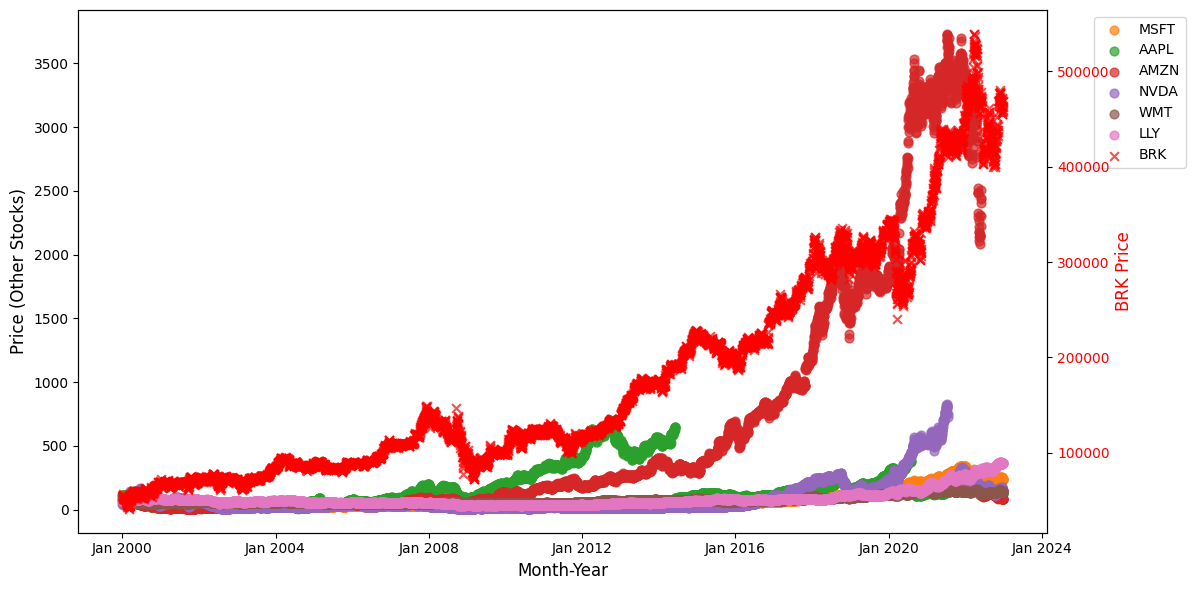

In [38]:
## Summarize stock data
def stock_summary(tickers, file_format="{}.csv"):
    """Analyze metrics with date range and dual-axis"""
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax2 = ax.twinx()
    metrics_data = []
    
    for idx, ticker in enumerate(tickers):
        try:
            # Load and format dates
            df = pd.read_csv(file_format.format(ticker))
            df['date'] = pd.to_datetime(df['yyyymmdd'], format='%Y%m%d')
            
            # Calculate metrics
            summary = {
                'Ticker': ticker,
                'Date Range': f"{df['date'].min().date()} to {df['date'].max().date()}",
                'Price_μ': round(df.dlyprc.mean(), 2),
                'Volatility': round(df.dlyprc.pct_change().std(), 2),
                'Obs Days': len(df)
            }
            metrics_data.append(summary)
            
            # Plot configuration
            color = 'red' if ticker == 'BRK' else f'C{idx}'
            marker = 'x' if ticker == 'BRK' else 'o'
            
            # Plot to appropriate axis
            if ticker == 'BRK':
                ax2.scatter(df['date'], df.dlyprc,
                          color=color, marker=marker,
                          s=40, alpha=0.7, label=ticker)
            else:
                ax.scatter(df['date'], df.dlyprc,
                         color=color, marker=marker,
                         s=40, alpha=0.7, label=ticker)
            
        except Exception as e:
            print(f"⚠️ Error processing {ticker}: {str(e)}")
    
    # Date formatting
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45)
    
    # Axis labels
    ax.set_xlabel('Month-Year', fontsize=12)
    ax.set_ylabel('Price (Other Stocks)', fontsize=12)
    ax2.set_ylabel('BRK Price', fontsize=12, color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Combined legend
    handles, labels = [], []
    for axis in [ax, ax2]:
        h, l = axis.get_legend_handles_labels()
        handles += h
        labels += l
    ax.legend(handles, labels, bbox_to_anchor=(1.15, 1))
    
    plt.tight_layout()
    
    return pd.DataFrame(metrics_data).style.format({
        'Price_μ': '{:.2f}',
        'Volatility': '{:.2f}'
    }).background_gradient(cmap='Blues', subset=['Price_μ', 'Volatility'])

# Usage
result = stock_summary(tickers)
display(result)

In [39]:
## Summarize option data
def options_overview(ticker_list):
    """Generate options data summary excluding BRK's implied vol"""
    summaries = []
    
    for ticker in ticker_list:
        try:
            df = pd.read_csv(f"{ticker}_options.csv", parse_dates=['date', 'exdate'])
            
            summary = {
                'Ticker': ticker,
                'Total Options': len(df),
                'Date Range': f"{df['date'].min().date()} to {df['date'].max().date()}",
                'Avg Options/Day': round(df.groupby('date')['strike_price'].count().mean(), 1),
                'Avg Strike Range': round((df.groupby('date')['strike_price'].max() - 
                                        df.groupby('date')['strike_price'].min()).mean(), 2),
                'Avg Bid Price': round(df['best_bid'].mean(), 2),
                'Moneyness Range': f"{round(df['strike_price'].min()/df['strike_price'].mean(), 1)}x - " +
                                 f"{round(df['strike_price'].max()/df['strike_price'].mean(), 1)}x"
            }
            
            # Skip implied vol for BRK
            if ticker != 'BRK':
                summary['Avg Implied Vol (%)'] = round(df['impl_volatility'].mean() * 100, 2)
            
            summaries.append(summary)
            
        except Exception as e:
            print(f"❌ {ticker} error: {str(e)}")
            continue
    
    return pd.DataFrame(summaries).set_index('Ticker')

# Usage
options_summary = options_overview(tickers)

# Format display
styled_summary = options_summary.style.format({
    'Avg Implied Vol (%)': '{:.2f}%',
    'Avg Bid Price': '${:.2f}',
    'Avg Strike Range': '${:.2f}'
}).background_gradient(cmap='Blues', subset=['Avg Implied Vol (%)', 'Avg Bid Price'])

display(styled_summary)

,Total Options,Date Range,Avg Options/Day,Avg Strike Range,Avg Bid Price,Moneyness Range,Avg Implied Vol (%)
Ticker,,,,,,,
BRK,739591,2009-06-18 to 2022-12-30,217.000000,$291753.89,$41.04,0.1x - 21.4x,nan%
MSFT,1321433,2000-01-03 to 2022-12-30,228.300000,$111894.07,$25.74,0.0x - 3.9x,39.59%
AAPL,2534970,2000-01-03 to 2022-12-30,438.000000,$299474.02,$50.81,0.0x - 16.4x,46.28%
AMZN,3748972,2000-01-03 to 2022-12-30,647.800000,$886592.28,$318.90,0.0x - 3.8x,45.08%
NVDA,1457027,2000-01-03 to 2022-12-30,251.800000,$173216.56,$55.01,0.0x - 7.7x,61.54%
WMT,777851,2000-01-03 to 2022-12-30,134.400000,$88538.53,$12.47,0.0x - 2.8x,33.79%
LLY,832769,2000-01-03 to 2022-12-30,143.900000,$103198.55,$23.49,0.1x - 4.8x,39.17%


In [40]:
## Summarize merged data with monthly option duration

def financial_metrics_report(ticker_list):
    """Financial metrics with date range and dynamic column handling"""
    metrics = []
    
    for ticker in ticker_list:
        try:
            # Load data without assuming specific columns
            df = pd.read_csv(
                f"{ticker}_merged.csv",
                parse_dates=['date', 'exdate'],
                dtype={'impl_volatility': float}
            )
            
            # Calculate date range
            start_date = df['date'].min().strftime('%Y-%m-%d') if not pd.isnull(df['date'].min()) else 'N/A'
            end_date = df['date'].max().strftime('%Y-%m-%d') if not pd.isnull(df['date'].max()) else 'N/A'
            
            # Check for required columns
            has_volatility = 'impl_volatility' in df.columns
            has_bid = 'best_bid' in df.columns
            has_stock_price = 'dlyprc_current' in df.columns
            
            # Initialize metrics with date range
            report = {
                'Ticker': ticker,
                'Start Date': start_date,
                'End Date': end_date,
                'Avg IV (%)': None,
                'Avg Bid Price': None,
                'Bid IV Corr': None,
                'OTM %': None,
                'Avg Days Expiry': None,
                'Strike Spread': None,
                'Volume': len(df)
            }
            
            # Calculate metrics only if columns exist
            if has_stock_price and 'strike_price' in df.columns:
                df['moneyness'] = df['strike_price'] / df['dlyprc_current']
                report['OTM %'] = (df['moneyness'] > 1).mean() * 100
                report['Strike Spread'] = df['strike_price'].max() - df['strike_price'].min()
                
            if has_bid:
                report['Avg Bid Price'] = df['best_bid'].mean()
                
            if has_volatility:
                report['Avg IV (%)'] = df['impl_volatility'].mean() * 100
                if has_bid:
                    report['Bid IV Corr'] = df['best_bid'].corr(df['impl_volatility'])
                    
            if 'exdate' in df.columns and 'date' in df.columns:
                report['Avg Days Expiry'] = (df['exdate'] - df['date']).dt.days.mean()
                
        except Exception as e:
            report = {
                'Ticker': ticker,
                'Start Date': 'N/A',
                'End Date': 'N/A',
                'Error': str(e)
            }
            
        metrics.append(report)
    
    return pd.DataFrame(metrics).set_index('Ticker').style.format({
        'Start Date': '{}',
        'End Date': '{}',
        'Avg IV (%)': '{:.2f}%',
        'Avg Bid Price': '${:.2f}',
        'Bid IV Corr': '{:.2f}',
        'OTM %': '{:.1f}%',
        'Avg Days Expiry': '{:.1f} days',
        'Strike Spread': '${:,.2f}',
        'Volume': '{:,}'
    }, na_rep="N/A")


# Execute
report = financial_metrics_report(['BRK','MSFT', 'AAPL', 'AMZN', 'NVDA', 'WMT', 'LLY'])
display(report)

,Start Date,End Date,Avg IV (%),Avg Bid Price,Bid IV Corr,OTM %,Avg Days Expiry,Strike Spread,Volume
Ticker,,,,,,,,,
BRK,2009-07-17,2022-12-30,N/A,$38.19,N/A,4.6%,43.6 days,"$4,580,000.00","4,980"
MSFT,2000-01-21,2022-12-30,49.20%,$19.48,0.40,100.0%,50.2 days,"$517,500.00","7,687"
AAPL,2000-01-21,2022-12-30,57.81%,$45.10,0.47,100.0%,41.5 days,"$1,047,500.00","15,630"
AMZN,2000-01-21,2022-12-30,51.68%,$249.67,0.41,100.0%,40.2 days,"$5,497,500.00","25,041"
NVDA,2000-01-21,2022-12-30,70.90%,$41.36,0.41,100.0%,48.0 days,"$1,248,750.00","9,778"
WMT,2000-01-21,2022-12-30,39.75%,$11.69,0.65,100.0%,40.8 days,"$227,500.00","4,892"
LLY,2000-01-21,2022-12-30,44.76%,$24.03,0.47,100.0%,45.0 days,"$527,500.00","5,607"


## Trading strategy ###

First we started to find the best strikes for each month. We did this by subtracting the strike price from the stock price at expiration date. Then we filtered for values smaller than 0, meaning only strikes that are greater than the stock price. From those we chose the strike with the least negative number. Based on those strikes we run our prediction model.

**Prediction**

We used the ordinary least square method to predict our future strike prices for our covered call strategy. We are assuming that there is a linear dependency between the stock price and the strike price. First we defined a cutoff date which treats all previous data as our training data to fit the model. Where variable “dlyprc_curr” represents the stock price as our independent variable. The variable “strike_prc” which represents the strike price is our dependent variable. We use following equation: strike_prc=β0​+β1​⋅dlyprc_curr+ϵ to get our linear regression. Based on our past data we use the current stock price to get our final strike price for every month.

Afterwards we did a volatility adjustment where we increased the strike price around 10% if the volatility is lower than its mean. If the volatility is higher than the mean we increase our strike price by 5%. The reason for that is, that stocks are rising when volatility is low and stocks are falling when volatility goes up. Those adjustments are assumed by us through iteration by hand.

**Strategy testing**
We calculate our return based on two different scenarios.

At expiration date the stock price is below the strike price. So, we calculate the return of the stock between option selling date (t0) and expiration date (t1). We subtract the option premium from t0 as the option premium is increasing our return.

At expiration date the stock price is above the strike price. This means that the option will be exercised and we have to deliver the stock. Here we do basically two calculations. First we calculate the loss from the exercise and second we calculate the loss of buying the stock again for a higher price.
In the end we subtract a fee of 2% from our monthly returns and calculate our cumulative returns afterwards.


### Solo stock performance ###

In [3]:
#predicted strike price model

from typing import TypeAlias, Literal
from pandas import DataFrame, Timestamp
import statsmodels.formula.api as smf

def predict_stock_price(df: DataFrame, cutoff_date: Timestamp) -> DataFrame:
    """
    Go through all rows since cutoff_date and predict the strike price one at a time.
    Adds the following columns:
        - strike_prc = strike_price / 1000 (corrected)
        - strike_prc_pred_ols = Prediction based on all previous values
        - strike_prc_pred_ols_vol = Prediction based on all previous values + volatility adjustment
        - pred_err_ols = difference between predicted strike price and stock actual stock price
        - pred_err_ols_vol = difference between predicted strike price (with volatility) and stock actual stock price
        - strike_prc_pred_ols_combined, strike_prc_pred_ols_vol_combined = combination of real values + predicted values (since cutoff date). Does not contain any NaN values.

    df is copied before being modified.
    :return: new df with added columns.
    """
    df = df.copy()

    # Data transformation
    df['strike_prc'] = df['strike_price'] / 1000 / df['dlycumfacpr_current']
    df['date'] = pd.to_datetime(df['date'])
    df['dlyprc_curr'] = df['dlyprc_current'] / df['dlycumfacpr_current']
    

    # Create column with adjusted stock price.
    if "strike_prc" not in df.columns:
        df["strike_prc"] = df["strike_price"] / 1000

    # Fail early if the df has not the correct format.
    for required_col in ["strike_prc", "dlyprc_curr", "date", "impl_volatility"]:
        if required_col not in df.columns:
            raise ValueError(f"Required column [{required_col}] is missing.")

    mean_volatility = df["impl_volatility"].mean()

    stock_prices = []
    strike_prices = []
    predicted_strike_prices = []
    predicted_strike_prices_with_volatility = []

    # Go through each row, train the Ordinary Least Squares model, and predict the next value
    # based on dlyprc_current.
    for row in df.iterrows():
        row_columns = row[1]
        date = row_columns["date"]
        historic_strike_price = row_columns["strike_prc"]
        stock_price = row_columns["dlyprc_curr"]

        if date >= cutoff_date:
            df_train = pd.DataFrame(
                {"dlyprc_curr": stock_prices, "strike_prc": strike_prices}
            )
            if df_train.empty:
                raise ValueError(
                    "There are no stock / strike data points to train to predict the future strike price. "
                    "Maybe choose a different cutoff date?."
                )

            mod = smf.ols(formula="strike_prc ~ dlyprc_curr", data=df_train)
            res = mod.fit()
            # Only predict next value using a single new value at a time
            df_pred = pd.DataFrame(
                {
                    "dlyprc_curr": [stock_price],
                }
            )
            predictions = res.predict(df_pred)
            predicted_strike_price = predictions[0]
            predicted_strike_prices.append(predicted_strike_price)  # Default prediction

            # Prediction with volatility
            current_volatility = row_columns["impl_volatility"]
            predicted_strike_prices_with_volatility.append(
                predicted_strike_price * 1.1
                if current_volatility <= mean_volatility
                else predicted_strike_price * 0.95
            )
        else:
            predicted_strike_prices.append(None)
            predicted_strike_prices_with_volatility.append(None)

        stock_prices.append(stock_price)
        strike_prices.append(historic_strike_price)

    df["strike_prc_pred_ols"] = predicted_strike_prices
    df["strike_prc_pred_ols_vol"] = predicted_strike_prices_with_volatility

    df["pred_err_ols"] = (
            df["strike_prc_pred_ols"] - df["strike_prc"]
    ).round()
    df["pred_err_ols_vol"] = (
            df["strike_prc_pred_ols_vol"] - df["strike_prc"]
    ).round()

    print("Prediction complete. Info:")
    print(df[["pred_err_ols", "pred_err_ols_vol"]].describe())

    df["strike_prc_pred_ols_combined"] = df["strike_prc_pred_ols"].fillna(
        df["strike_prc"])
    df["strike_prc_pred_ols_vol_combined"] = df["strike_prc_pred_ols_vol"].fillna(
        df["strike_prc"])

    return df

# For debugging purposes
#apple_pred = predict_stock_price(data_sample_return, Timestamp("2020-01-01"))
#apple_pred

In [7]:
## Write option strategy

def load_data(filename):
    """Load stock options data from a CSV file."""
    return pd.read_csv(filename)

def preprocess_data(data):
    """Preprocess data by selecting relevant columns and calculating price factor."""
    required_columns = ['ticker_current', 'date', 'exdate', 'dlyprc_current',
                       'dlycumfacpr_current', 'strike_price', 'best_bid',
                       'dlyprc_strike', 'dlycumfacpr_strike']
    
    if not set(required_columns).issubset(data.columns):
        missing = set(required_columns) - set(data.columns)
        raise ValueError(f"Missing required columns: {missing}")
    
    processed_data = data[required_columns].copy()
    processed_data['price_factor'] = processed_data['dlycumfacpr_current'] / processed_data['dlycumfacpr_strike']
    return processed_data

def select_best_option(data, benchmark_column,selection_column='best_bid'):
    """
    Select the best strike price based on a chosen strike price column and selection column.
    
    Parameters:
    - data (DataFrame): The dataset containing options data.
    - strike_column (str): The column to use for strike price (e.g., 'dlyprc_strike' or a predicted column).
    - selection_column (str): The column to use for selecting the best option (e.g., 'best_bid', 'best_ask').

    Returns:
    - DataFrame: The filtered data with the best strike price per date.
    """
    
    # Adjust for stock splits and dividends
    data['price_factor'] = data.dlycumfacpr_current / data.dlycumfacpr_strike  

    # Calculate strike deviation using the selected strike column
    data['strike_deviation'] = (data[benchmark_column] * data.price_factor - (data.strike_price / 1000))

    # Keep only strikes below the target price
    filtered_data = data[data['strike_deviation'] < 0]

    # Find the best strike per date based on the chosen selection column
    best_options = filtered_data.loc[filtered_data.groupby('date')[selection_column].idxmax()]

    return best_options

def option_strategy(data, cutoff_date):
    """
    Determines the best option strategy by selecting the best historical and predicted strike prices.

    Parameters:
    - data (DataFrame): The dataset containing options data.
    - cutoff_date (Timestamp): The date for which the prediction will be made.

    Returns:
    - DataFrame: The best options based on historical and predicted strike prices.
    """
    
    # Find the previous best strike price
    best_historical = select_best_option(data,'dlyprc_strike')

    # Store in a DataFrame
    mark_and_filter_options(data, best_historical )

    # Predict the strike price for the next cutoff date
    predicted_data = predict_stock_price(data, cutoff_date)

    # Find the best strike price near the prediction
    best_predicted = select_best_option(predicted_data,'strike_prc_pred_ols_vol')

    return best_predicted
    
def mark_and_filter_options(data, option_indices):
    """Mark selected options and filter dataset."""
    data['option_position'] = 0
    data.loc[option_indices, 'option_position'] = 1
    return data[data['option_position'] == 1].copy()

def calculate_returns(data, fees=0.04):
    """Calculate financial returns and cumulative performance."""
    data = data.dropna().copy()
    data['price_factor'] = data['dlycumfacpr_current'] / data['dlycumfacpr_strike']
    
    # Stock returns calculation
    data['stock_return'] = (data['dlyprc_strike'] * data['price_factor'] - data['dlyprc_current']) / data['dlyprc_current']
    data['stock_cum_return'] = (1 + data['stock_return']).cumprod()
    
    # Option position logic
    data['stock_position'] = np.where(
        data['dlyprc_strike'] > ((data['strike_price'] / 1000) / data['price_factor']),
        1, 0
    )
    
    # Call returns calculation
    data['call_return'] = np.where(
        data['stock_position'] == 0,
        (data['best_bid'] + data['dlyprc_strike'] * data['price_factor'] - data['dlyprc_current']) / data['dlyprc_current'],
        (data['best_bid'] + (data['strike_price'] / 1000) - data['dlyprc_strike'] * data['price_factor']) / data['dlyprc_current']
    )
    
    # Apply transaction fees
    data['call_cum_return'] = (1 - fees + data['call_return']).cumprod()
    
    return data

# Example usage for any stock:
def process_stock_data(filename,cutoff_date,fees=0.04):
    """Complete processing pipeline for any stock data."""
    data = load_data(filename)
    data = preprocess_data(data)
    option_indices = option_strategy(data,cutoff_date)
    filtered_data = mark_and_filter_options(data, option_indices)
    results = calculate_returns(filtered_data, fees)
    
    # Save outputs
    option_indices.to_csv("option_decision.csv", index=False)
    results.to_csv("returns_results.csv", index=False)
    
    return results

In [5]:
## Apply the strategy to all of the stocks

def process_multiple_tickers(ticker_list,
                             cutoff_date,
                            file_format="{}_merged.csv", 
                            fees=0.04, 
                            start_date=None, 
                            end_date=None,
                            output_dir="results"):
    """
    Process options data for multiple tickers with date range filtering
    
    Parameters:
    ticker_list (list): List of stock tickers to process
    file_format (str): Format string for input filenames
    fees (float): Transaction fees percentage
    start_date (str): Start date in 'YYYY-MM-DD' format
    end_date (str): End date in 'YYYY-MM-DD' format
    output_dir (str): Output directory path
    
    Returns:
    dict: Dictionary of processed DataFrames with date-filtered results
    """
    import os
    from pathlib import Path
    
    # Create output directory
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    results = {}
    
    for ticker in ticker_list:
        try:
            input_file = file_format.format(ticker)
            print(f"Processing {ticker} from {input_file}...")
            
            # Load and process data with date filtering
            raw_data = load_data(input_file)
            processed_data = preprocess_data(raw_data)
            
            # Apply date filtering
            filtered_data = filter_by_dates(processed_data, start_date, end_date)
            
            if filtered_data.empty:
                print(f"⚠️ No data for {ticker} in date range {start_date} to {end_date}, skipping...")
                continue
                
            # Option selection and return calculation
            option_indices = option_strategy(filtered_data,cutoff_date)
            final_data = mark_and_filter_options(filtered_data, option_indices)
            ticker_results = calculate_returns(final_data, fees)
            
            # Save outputs
            option_indices.to_csv(
                os.path.join(output_dir, f"{ticker}_option_decision.csv"), 
                index=False
            )
            ticker_results.to_csv(
                os.path.join(output_dir, f"{ticker}_returns.csv"), 
                index=False
            )
            
            results[ticker] = ticker_results
            
        except FileNotFoundError:
            print(f"⚠️ Input file missing for {ticker}, skipping...")
        except Exception as e:
            print(f"❌ Error processing {ticker}: {str(e)}")
    
    print(f"\nProcessing complete. {len(results)}/{len(ticker_list)} tickers successfully processed")
    return results

# Supporting date filter function
def filter_by_dates(data, start_date=None, end_date=None):
    """Filter DataFrame by date range"""
    if data.empty:
        return data
    
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values('date').set_index('date')
    
    if start_date:
        start = pd.to_datetime(start_date)
        data = data.loc[data.index >= start]
    
    if end_date:
        end = pd.to_datetime(end_date)
        data = data.loc[data.index <= end]
    
    return data.reset_index()


In [83]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from pathlib import Path

def load_data(filename):
    """Load stock options data from a CSV file."""
    return pd.read_csv(filename)

def preprocess_data(data):
    """Preprocess data by selecting relevant columns and calculating price factor."""
    required_columns = ['ticker_current', 'date', 'exdate', 'dlyprc_current',
                        'dlycumfacpr_current', 'strike_price', 'best_bid',
                        'dlyprc_strike', 'dlycumfacpr_strike','impl_volatility']
    if not set(required_columns).issubset(data.columns):
        missing = set(required_columns) - set(data.columns)
        raise ValueError(f"Missing required columns: {missing}")
    
    data = data[required_columns].copy()
    data['price_factor'] = data['dlycumfacpr_current'] / data['dlycumfacpr_strike']
    return data

def filter_by_dates(data, start_date=None, end_date=None):
    """Filter DataFrame by date range."""
    if data.empty:
        return data
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values('date').set_index('date')
    if start_date:
        data = data.loc[data.index >= pd.to_datetime(start_date)]
    if end_date:
        data = data.loc[data.index <= pd.to_datetime(end_date)]
    return data.reset_index()

def select_best_option(data, benchmark_column, selection_column='best_bid'):
    """Select the best strike price based on a chosen column."""
    data['strike_deviation'] = (data[benchmark_column] * data.price_factor - (data.strike_price / 1000))
    filtered_data = data[data['strike_deviation'] < 0]
    return filtered_data.loc[filtered_data.groupby('date')[selection_column].idxmax()]

def predict_stock_price(df, cutoff_date):
    """Predict strike price for future dates using OLS regression."""
    df = df.copy()
    df['strike_prc'] = df['strike_price'] / 1000 / df['dlycumfacpr_current']
    df['date'] = pd.to_datetime(df['date'])
    df['dlyprc_curr'] = df['dlyprc_current'] / df['dlycumfacpr_current']
    
    mean_volatility = df['impl_volatility'].mean()
    stock_prices, strike_prices, pred_prices, pred_prices_vol = [], [], [], []
    
    for _, row in df.iterrows():
        if row['date'] >= cutoff_date:
            df_train = pd.DataFrame({"dlyprc_curr": stock_prices, "strike_prc": strike_prices})
            if df_train.empty:
                raise ValueError("No historical data available for prediction.")
            model = smf.ols(formula="strike_prc ~ dlyprc_curr", data=df_train).fit()
            predicted = model.predict(pd.DataFrame({"dlyprc_curr": [row['dlyprc_curr']]}))[0]
            pred_prices.append(predicted)
            pred_prices_vol.append(predicted * 1.1 if row['impl_volatility'] <= mean_volatility else predicted * 0.95)
        else:
            pred_prices.append(None)
            pred_prices_vol.append(None)
        stock_prices.append(row['dlyprc_curr'])
        strike_prices.append(row['strike_prc'])
    
    df['strike_prc_pred_ols'] = pred_prices
    df['strike_prc_pred_ols_vol'] = pred_prices_vol
    df['strike_prc_pred_ols_combined'] = df['strike_prc_pred_ols'].fillna(df['strike_prc'])
    df['strike_prc_pred_ols_vol_combined'] = df['strike_prc_pred_ols_vol'].fillna(df['strike_prc'])
    return df

def mark_and_filter_options(data, option_indices):
    """Mark selected options and filter dataset."""
    data['option_position'] = 0
    data.loc[option_indices.index, 'option_position'] = 1
    return data[data['option_position'] == 1].copy()

def calculate_returns(data, fees=0.04):
    """Calculate financial returns."""
    data = data.dropna().copy()
    data['stock_return'] = (data['dlyprc_strike'] * data['price_factor'] - data['dlyprc_current']) / data['dlyprc_current']
    data['stock_cum_return'] = (1 + data['stock_return']).cumprod()
    data['stock_position'] = np.where(
        data['dlyprc_strike'] > ((data['strike_price'] / 1000) / data['price_factor']), 1, 0)
    data['call_return'] = np.where(
        data['stock_position'] == 0,
        (data['best_bid'] + data['dlyprc_strike'] * data['price_factor'] - data['dlyprc_current']) / data['dlyprc_current'],
        (data['best_bid'] + (data['strike_price'] / 1000) - data['dlyprc_strike'] * data['price_factor']) / data['dlyprc_current']
    )
    data['call_cum_return'] = (1 - fees + data['call_return']).cumprod()
    return data

def option_strategy(data, cutoff_date):
    """Determine the best option strategy using historical and predicted strike prices."""
    best_historical = select_best_option(data, 'dlyprc_strike')
    marked_data = mark_and_filter_options(data, best_historical)
    predicted_data = predict_stock_price(marked_data, cutoff_date)

    merged_date = data.join(
        predicted_data.copy().set_index('date').add_suffix('_ols'),
        on = 'date')

    merged_date['strike_prc_pred_ols_vol_ols'] = merged_date['strike_prc_pred_ols_vol_ols'] * merged_date['dlycumfacpr_current']
    
    return select_best_option(merged_date, 'strike_prc_pred_ols_vol_ols')




In [84]:
def process_stock_data(filename, cutoff_date, fees=0.02):
    """Pipeline to process a single stock's options data."""
    data = preprocess_data(load_data(filename))
    best_options = option_strategy(data, cutoff_date)
    filtered_data = mark_and_filter_options(data, best_options)
    results = calculate_returns(filtered_data, fees)


    
    best_options.to_csv("option_decision.csv", index=False)
    results.to_csv("returns_results.csv", index=False)
    return results

def process_multiple_tickers(ticker_list, cutoff_date, file_format="{}_merged.csv", fees=0.02, start_date=None, end_date=None, output_dir="results"):
    """Process options data for multiple tickers with date filtering."""
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    results = {}
    for ticker in ticker_list:
        try:
            data = preprocess_data(load_data(file_format.format(ticker)))
            data = filter_by_dates(data, start_date, end_date)
            if data.empty:
                continue

            best_historical = select_best_option(data, 'dlyprc_strike')
            marked_data = mark_and_filter_options(data, best_historical)
            predicted_data = predict_stock_price(marked_data, cutoff_date)
            
            option_indices = option_strategy(data, cutoff_date)
            filtered_data = mark_and_filter_options(data, option_indices)
            ticker_results = calculate_returns(filtered_data, fees)



            predicted_data.to_csv(f"{output_dir}/{ticker}_predicted_data.csv", index=False)
            
            filtered_data.to_csv(f"{output_dir}/{ticker}_filtered_data.csv", index=False)
            option_indices.to_csv(f"{output_dir}/{ticker}_option_decision.csv", index=False)
            ticker_results.to_csv(f"{output_dir}/{ticker}_returns.csv", index=False)
            results[ticker] = ticker_results
        except Exception as e:
            print(f"Error processing {ticker}: {str(e)}")
    return results


In [99]:
# Execute the strategy with all tickers data
tickers = ['BRK','MSFT', 'AAPL', 'AMZN', 'NVDA', 'WMT', 'LLY']

test = process_multiple_tickers(
    tickers,
    cutoff_date= Timestamp("2020-01-01"),
    start_date='2000-01-01',
    end_date='2022-12-31',
    file_format="{}_merged.csv",
    fees=0.02,
    output_dir="options_analysis"
)

Error processing BRK: Missing required columns: {'impl_volatility'}


Error processing BRK: Missing required columns: {'impl_volatility'}


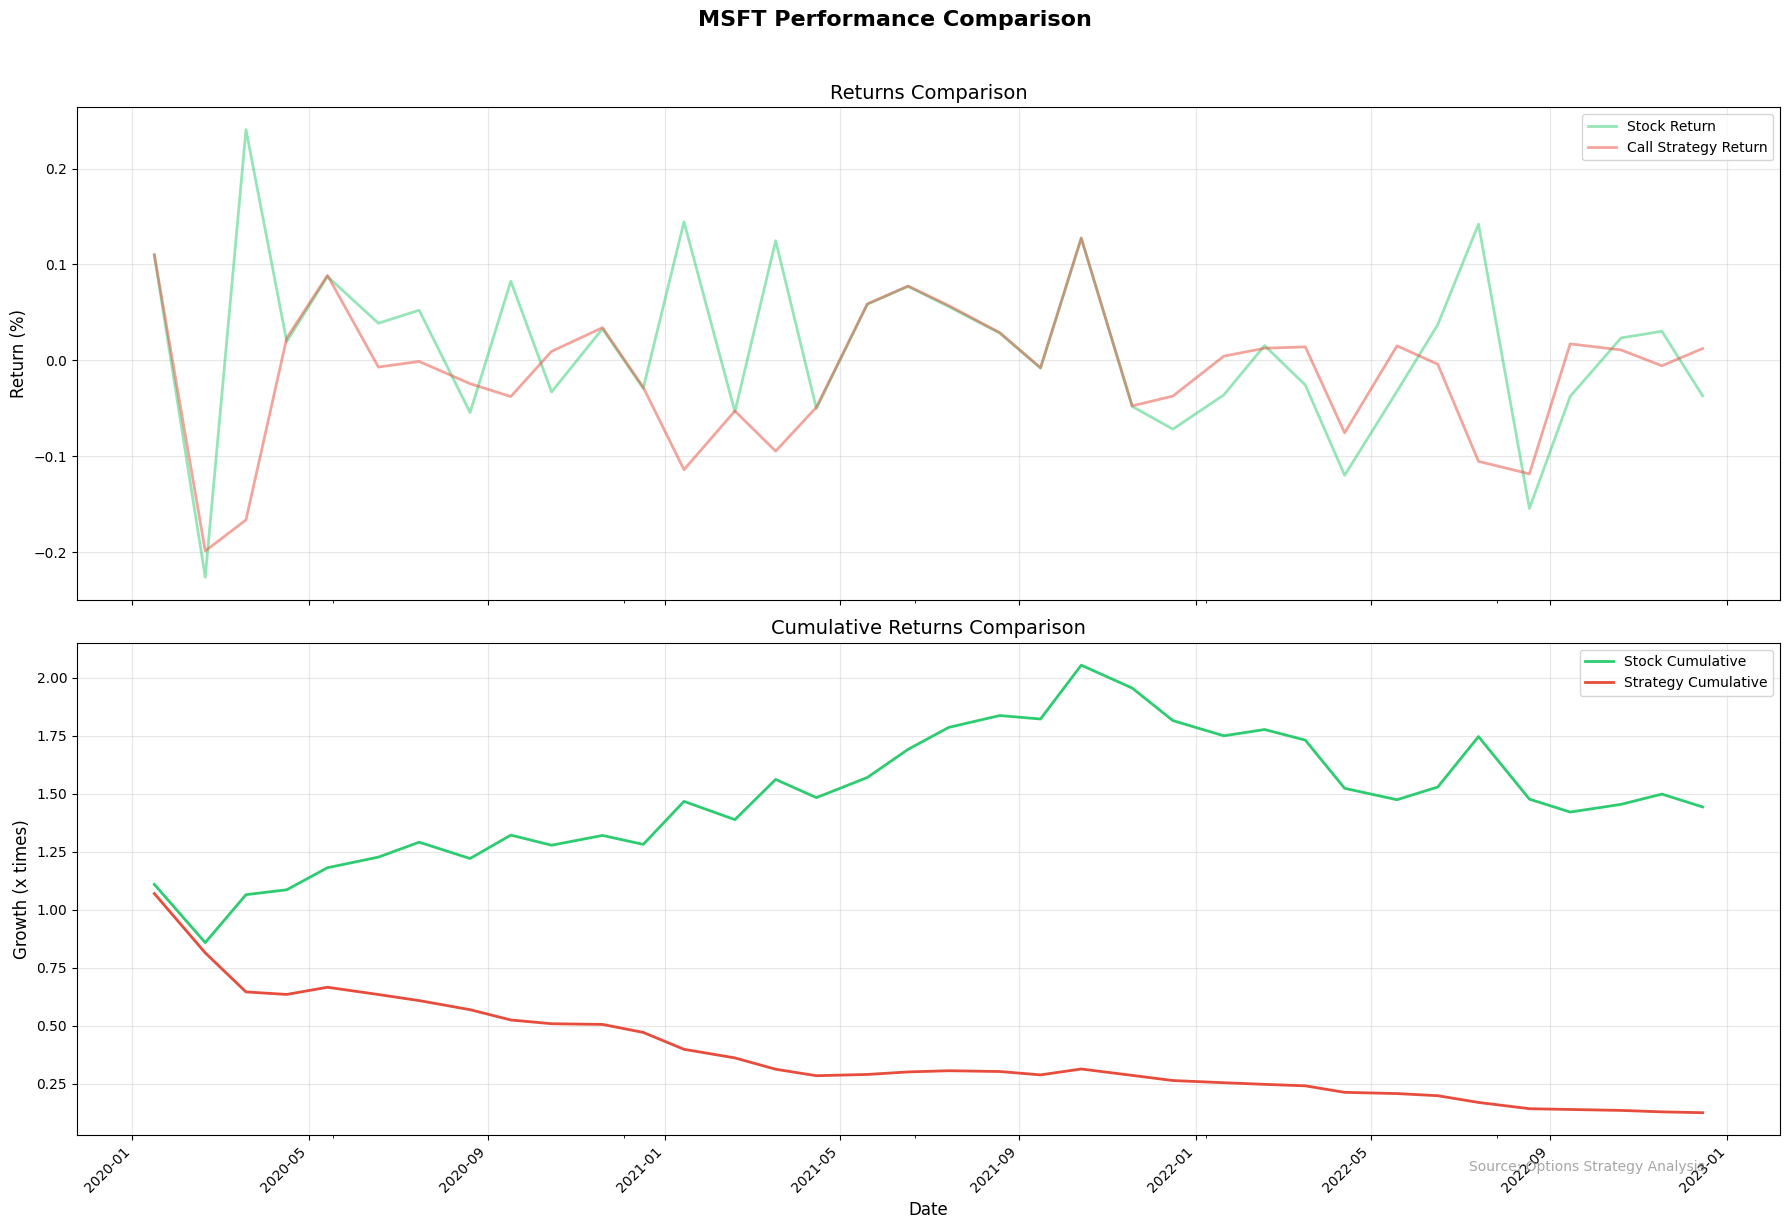

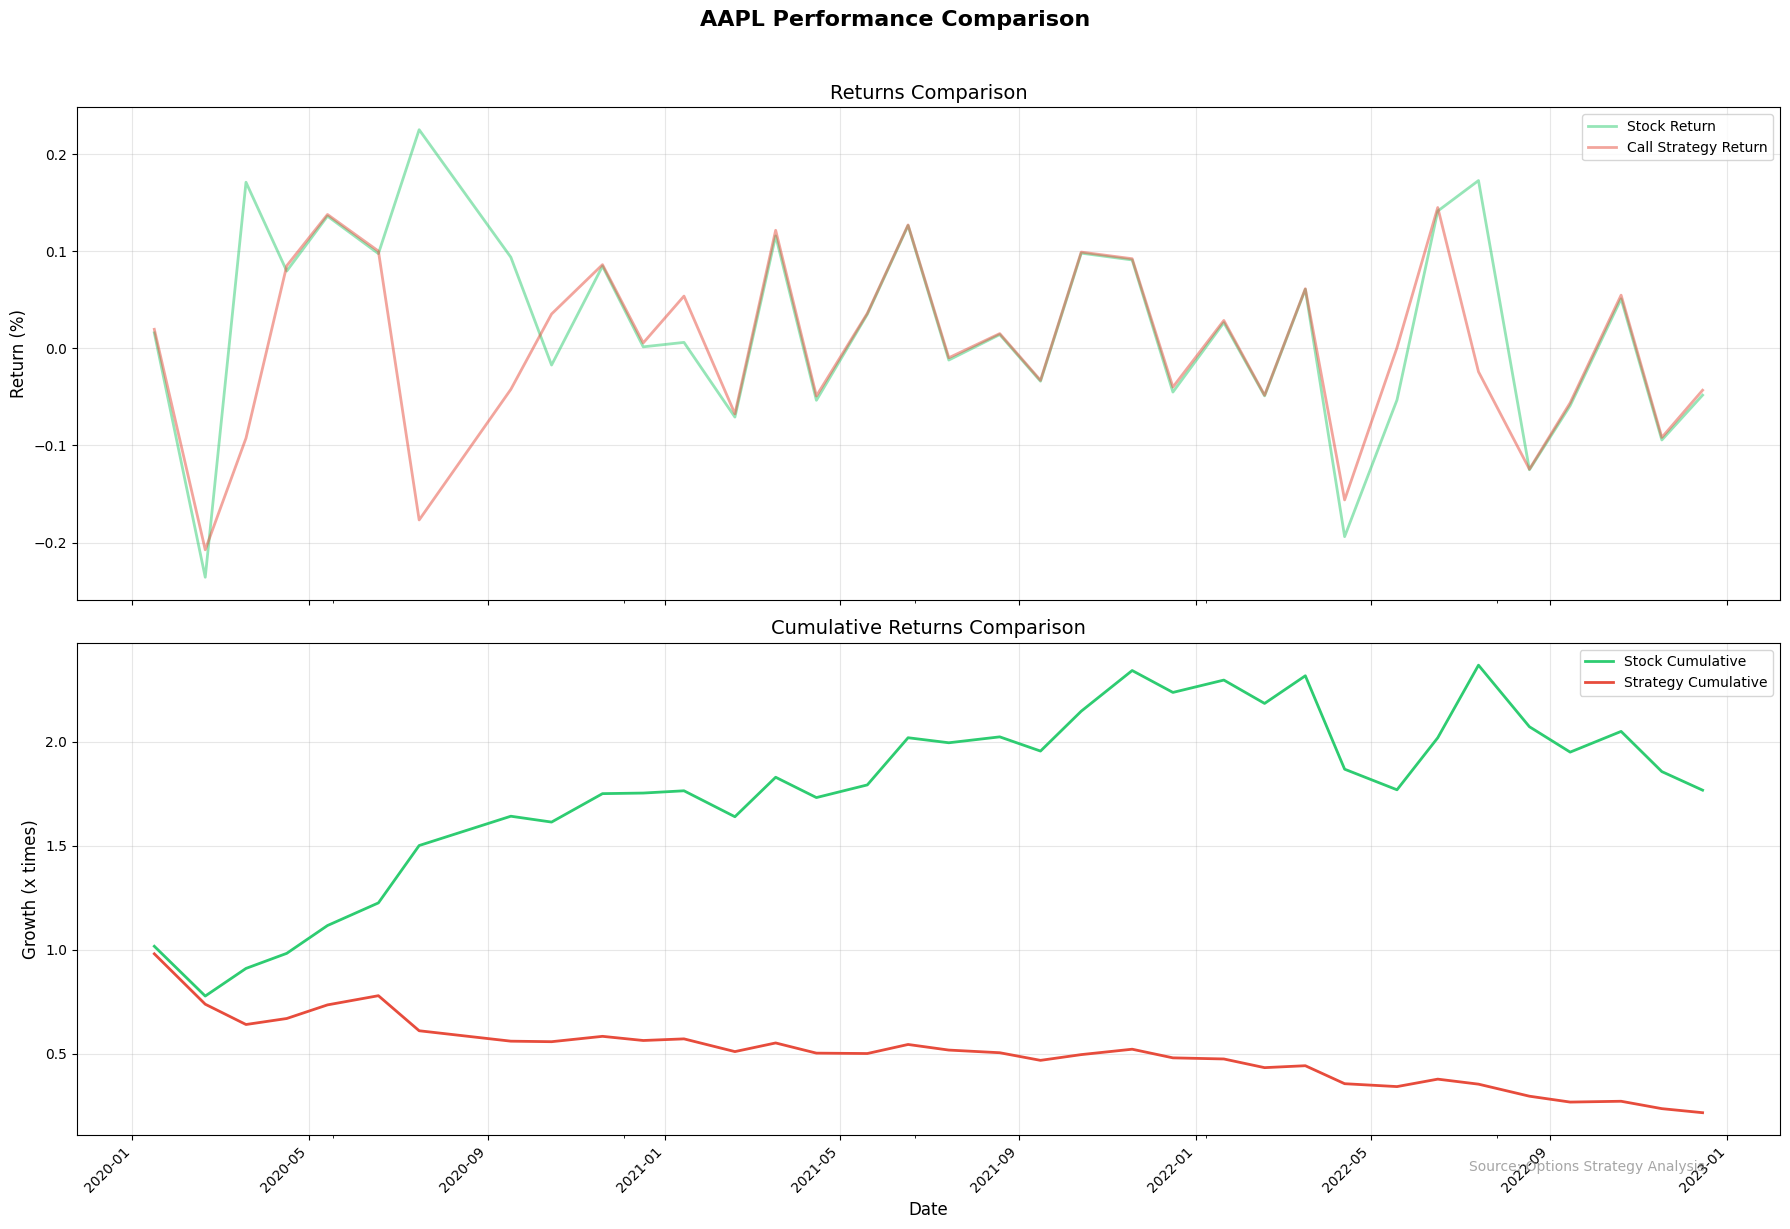

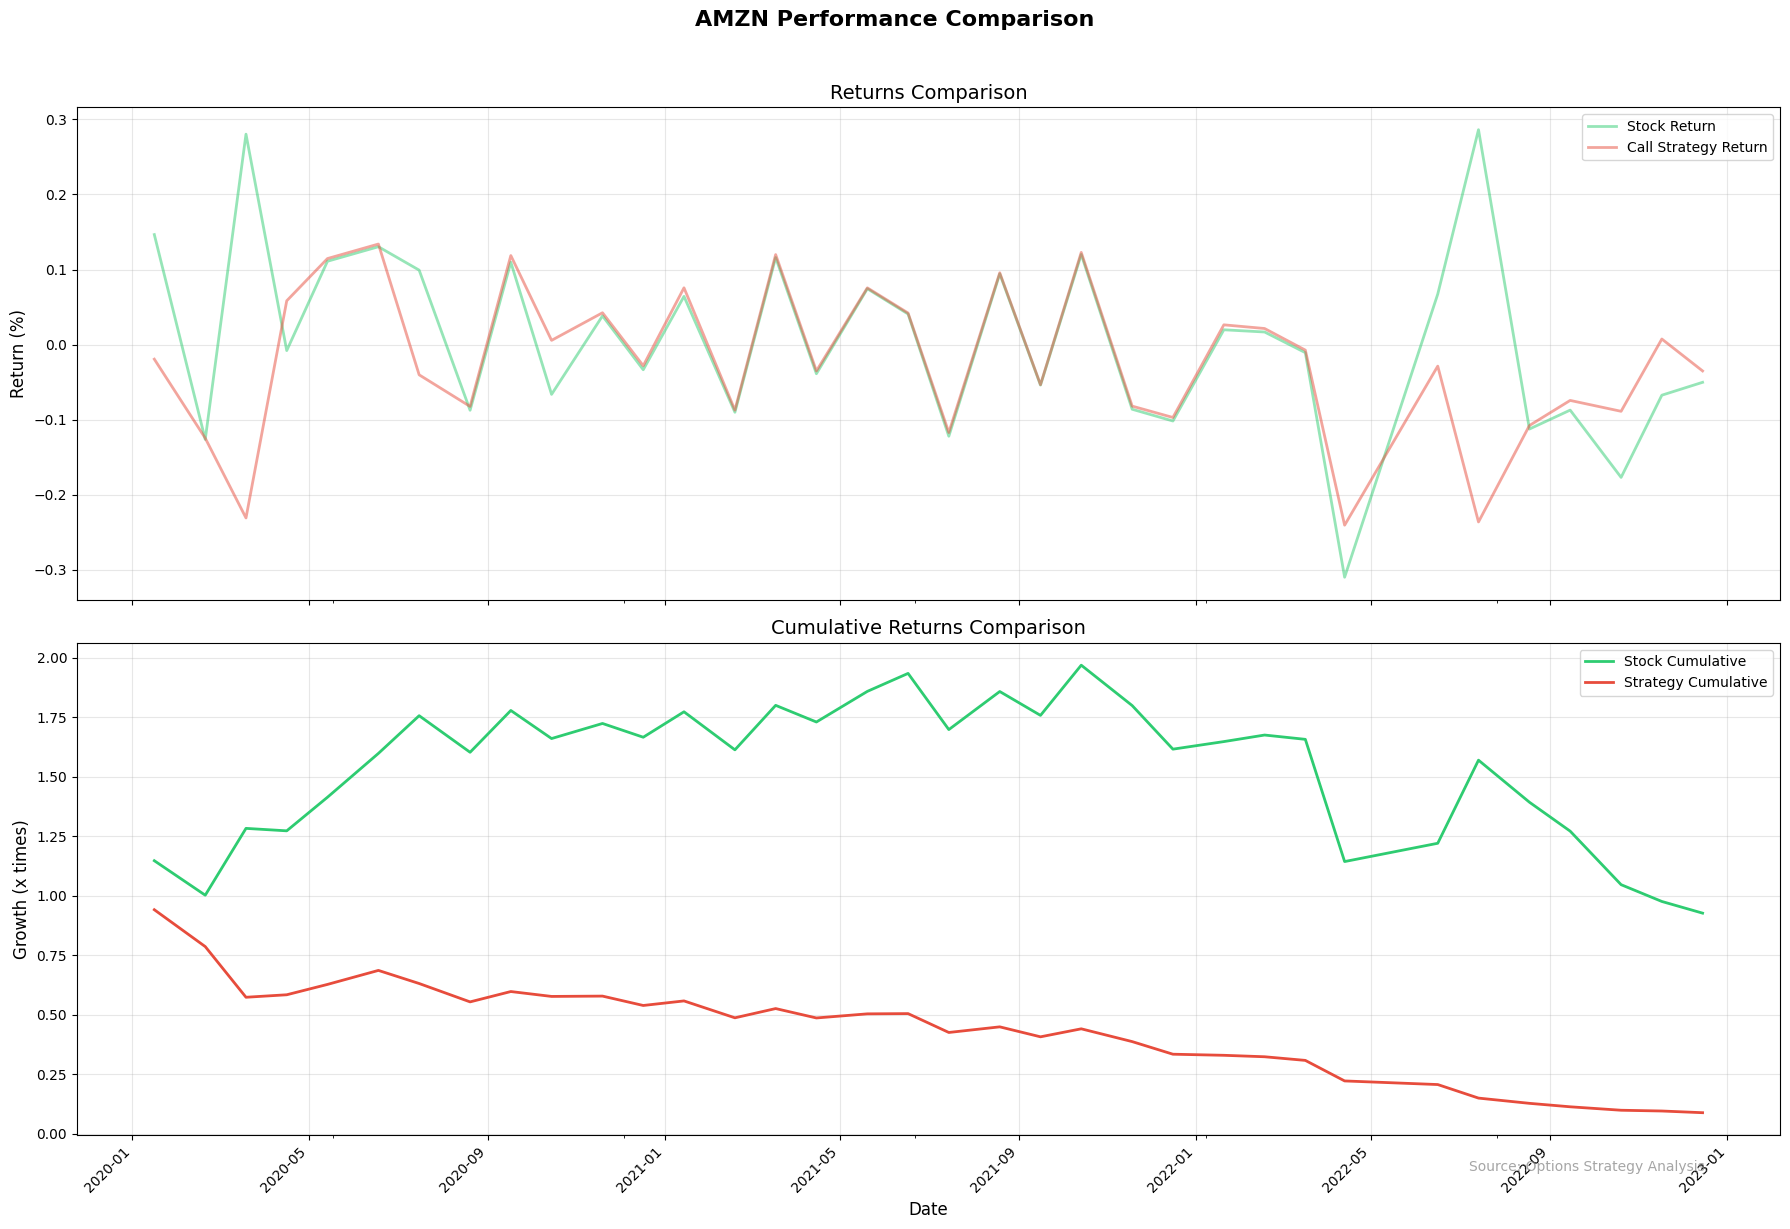

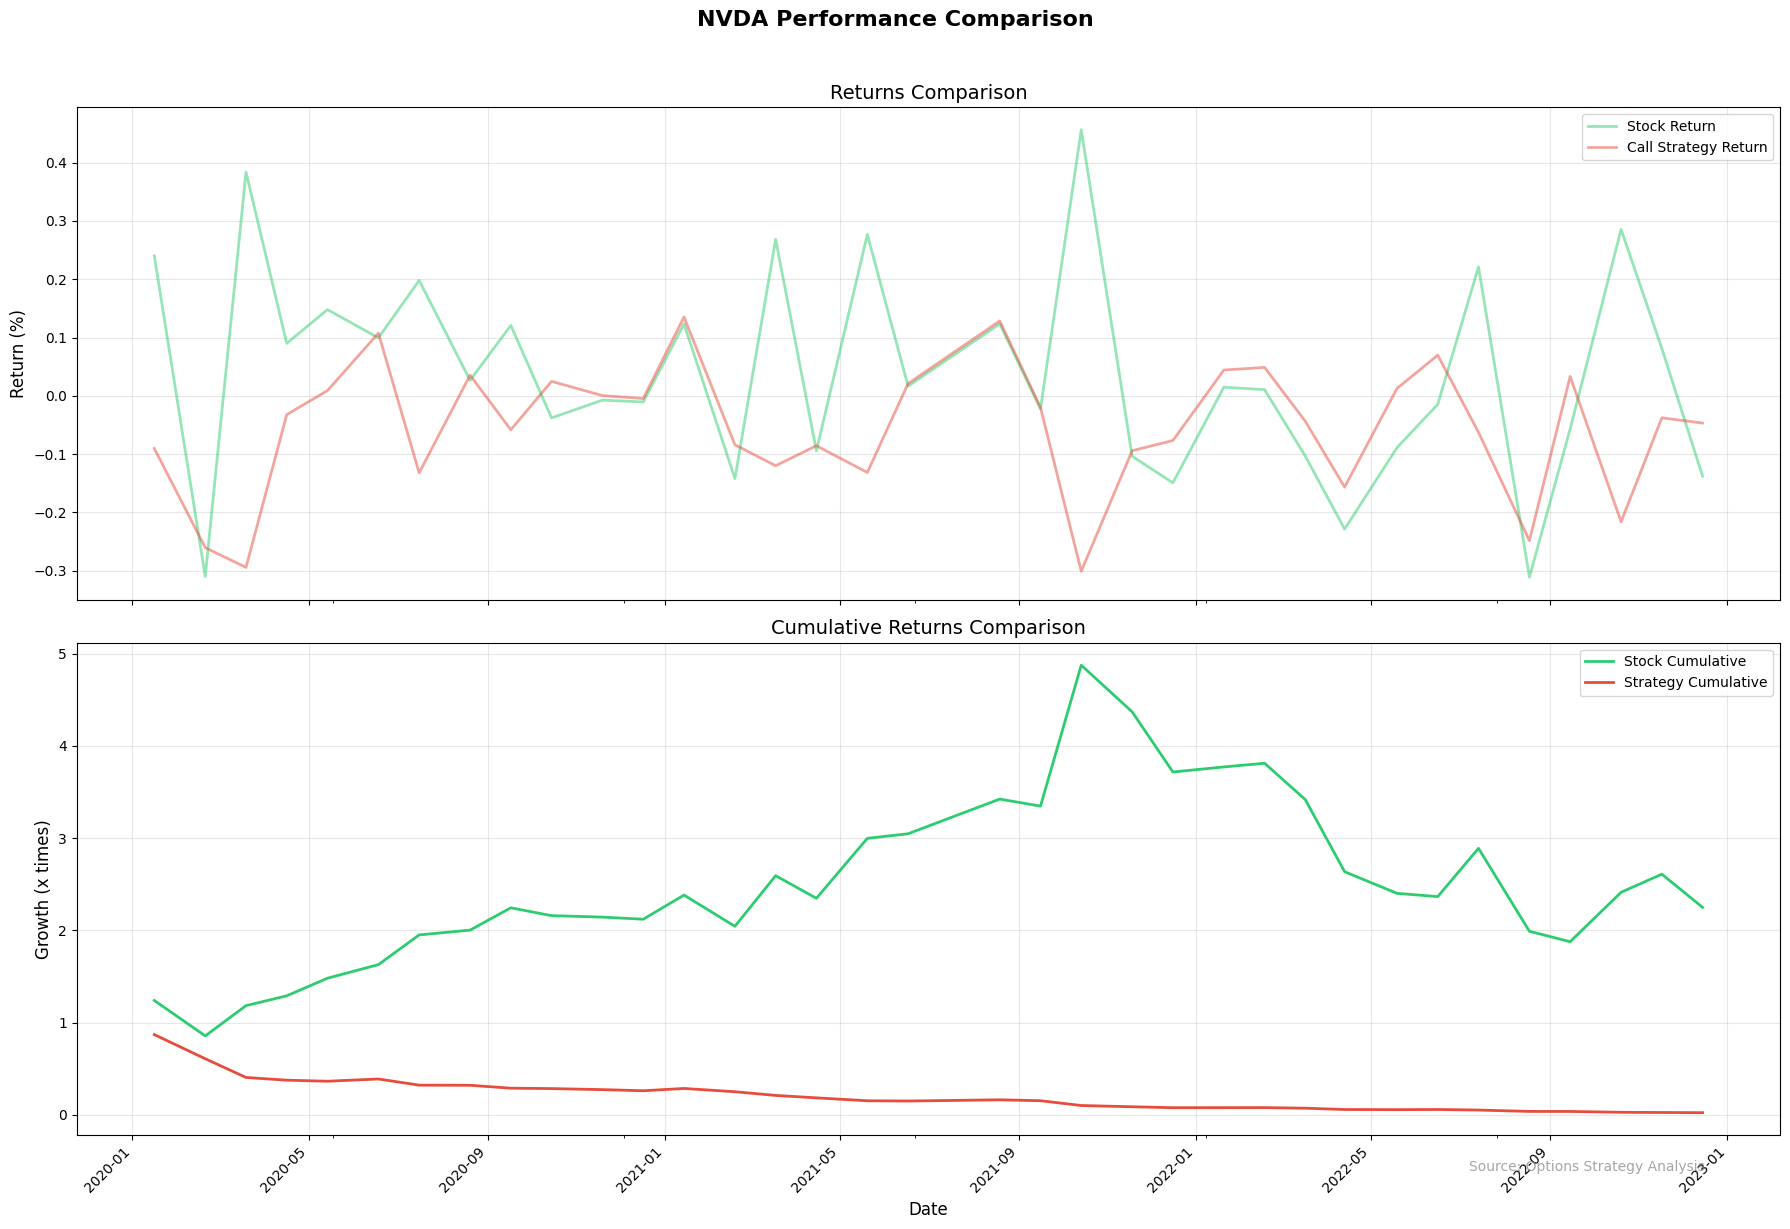

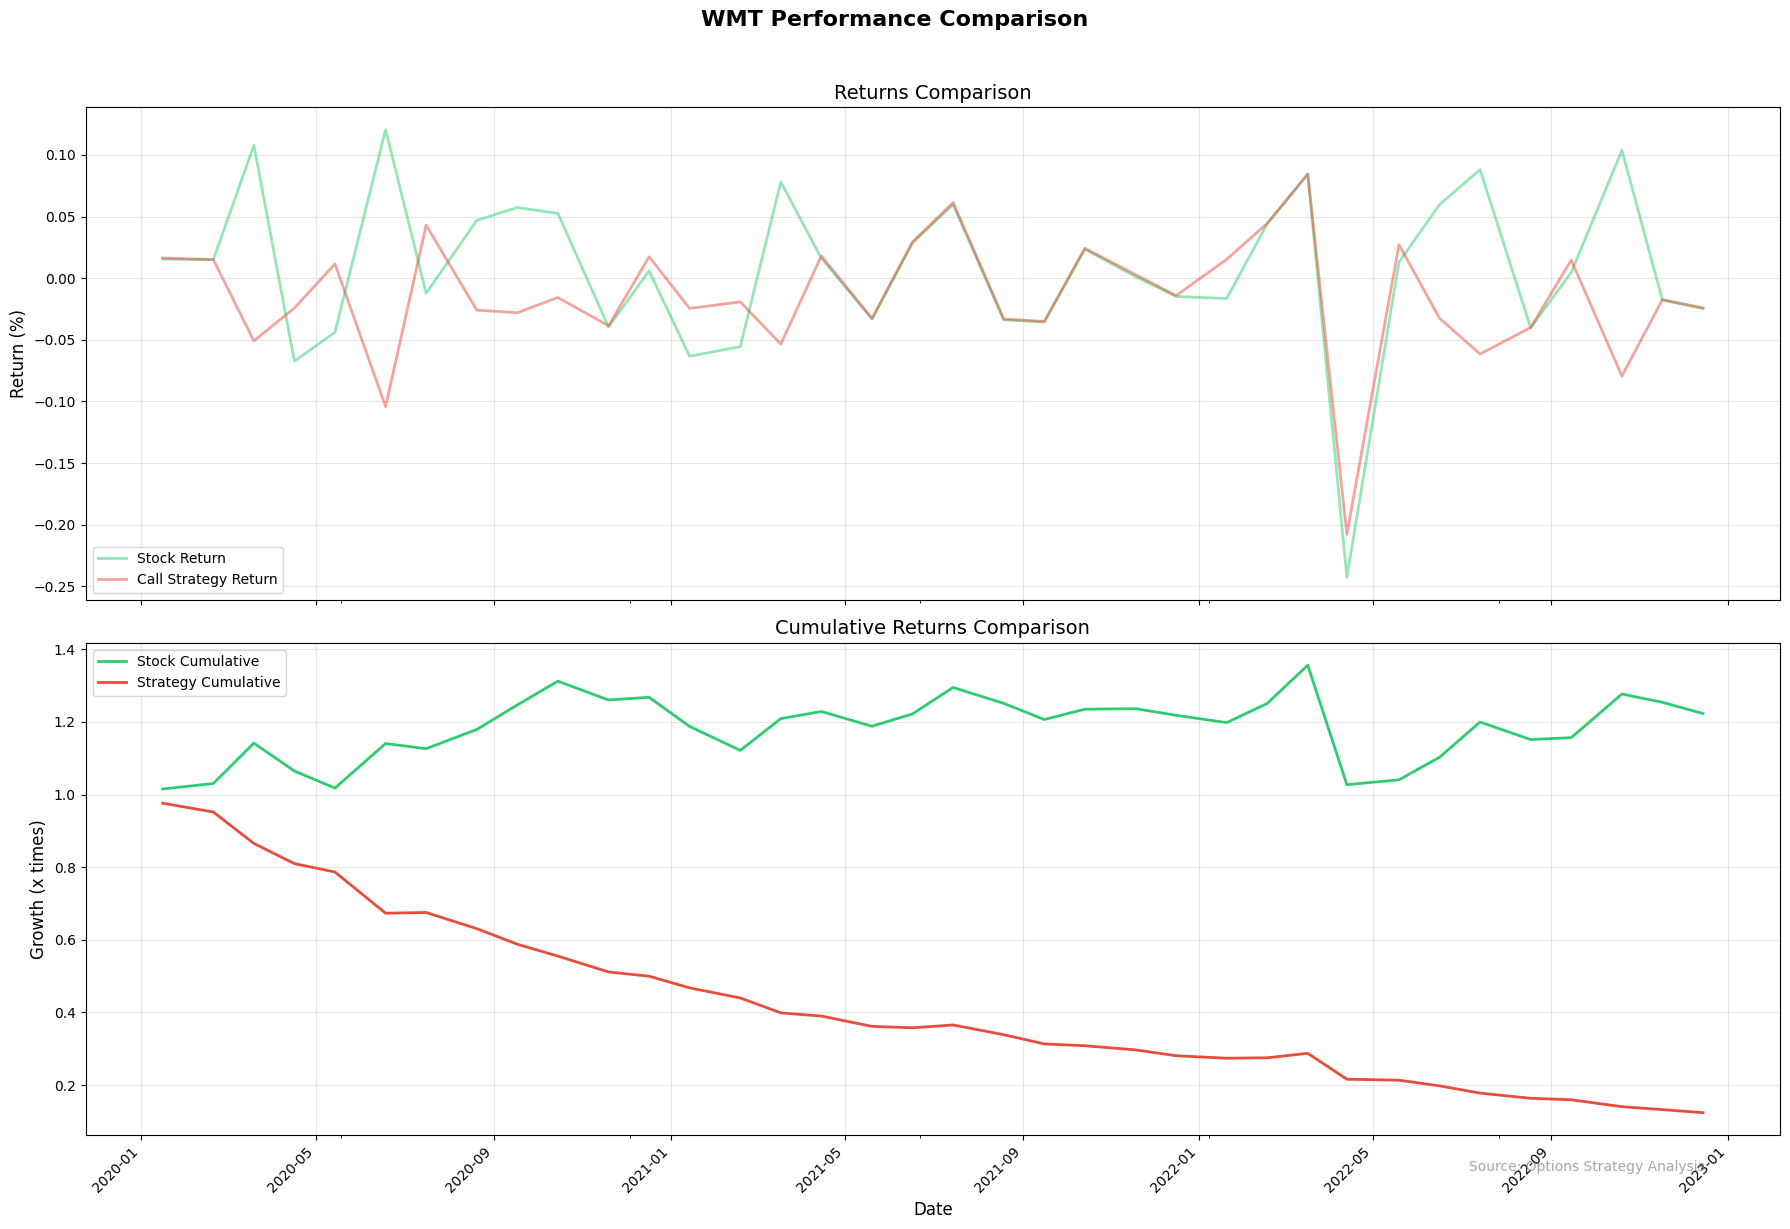

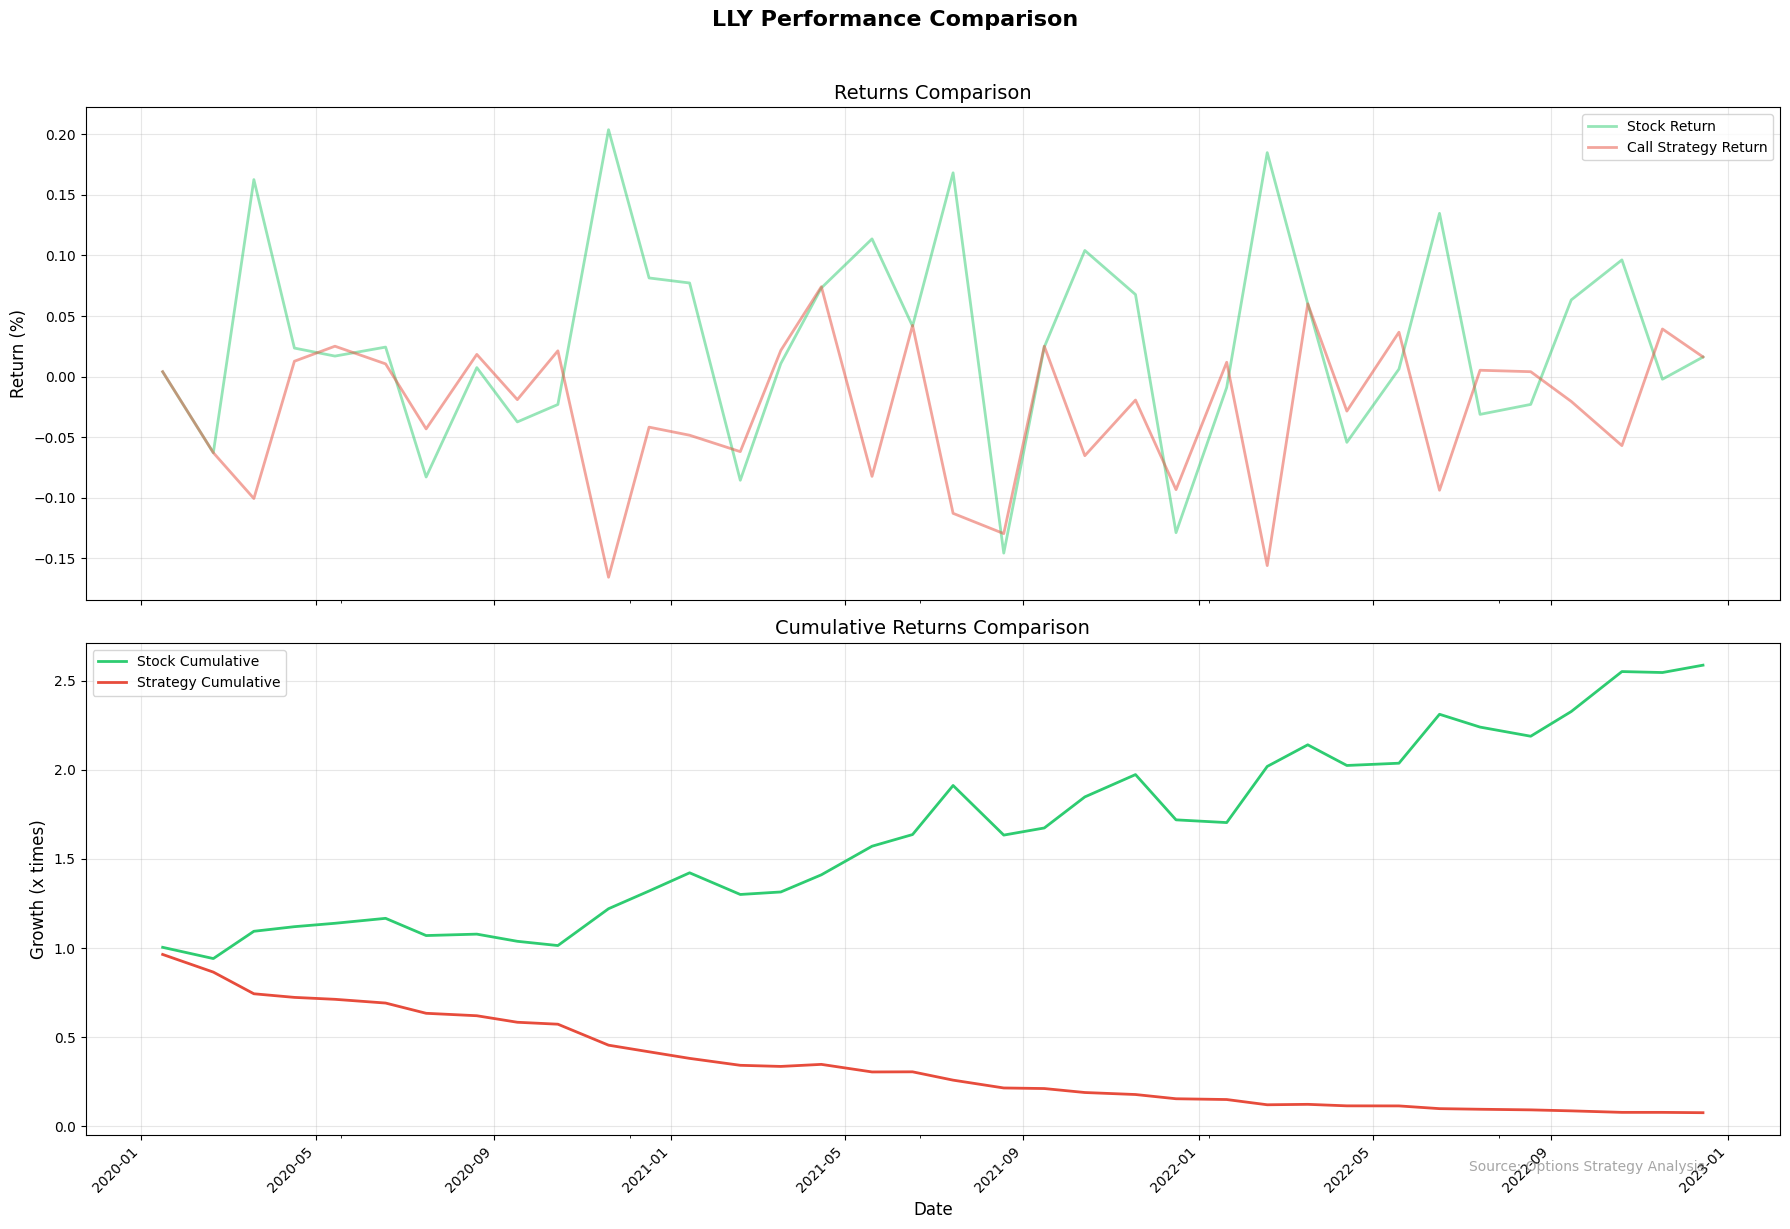

In [66]:
# Visualization (compared with buy-and-hold strategy)

import matplotlib.pyplot as plt
import pandas as pd

def plot_stock_vs_strategy(results_dict, figsize=(16, 12), start_date=None, end_date=None):
    """
    Plot comparative analysis between stock returns and call strategy returns for each ticker.
    
    Parameters:
    results_dict (dict): Dictionary of DataFrames from process_multiple_tickers()
    figsize (tuple): Figure dimensions (width, height)
    start_date (str): Optional start date filter (YYYY-MM-DD)
    end_date (str): Optional end date filter (YYYY-MM-DD)
    """
    colors = ['#2ecc71', '#e74c3c']  # Green for stock, red for strategy
    
    for ticker, df in results_dict.items():
        # Prepare data
        df = df.copy()
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date').set_index('date')
        
        # Apply date filters
        if start_date:
            df = df.loc[pd.to_datetime(start_date):]
        if end_date:
            df = df.loc[:pd.to_datetime(end_date)]
        
        # Create figure
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True)
        fig.suptitle(f'{ticker} Performance Comparison', y=1.02, fontsize=16, fontweight='bold')
        
        # Daily Returns Plot
        df['stock_return'].plot(ax=ax1, label='Stock Return', color=colors[0], linewidth=2, alpha=0.5)
        df['call_return'].plot(ax=ax1, label='Call Strategy Return', color=colors[1], linewidth=2, alpha=0.5)
        ax1.set_title('Returns Comparison', fontsize=14)
        ax1.set_ylabel('Return (%)', fontsize=12)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Cumulative Returns Plot
        df['stock_cum_return'].plot(ax=ax2, label='Stock Cumulative', color=colors[0], linewidth=2)
        df['call_cum_return'].plot(ax=ax2, label='Strategy Cumulative', color=colors[1], linewidth=2)
        ax2.set_title('Cumulative Returns Comparison', fontsize=14)
        ax2.set_ylabel('Growth (x times)', fontsize=12)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Formatting
        plt.xticks(rotation=45)
        plt.xlabel('Date', fontsize=12)
        plt.tight_layout()
        
        # Add watermark
        fig.text(0.95, 0.05, 'Source: Options Strategy Analysis',
                fontsize=10, color='gray', ha='right', va='bottom', alpha=0.7)
        
        plt.show()

results = process_multiple_tickers(
    tickers,
    cutoff_date= Timestamp("2020-01-01"),
    start_date='2000-01-01',
    end_date='2022-12-31',
    file_format="{}_merged.csv",
    fees=0.04,
    output_dir="options_analysis"
)
plot_stock_vs_strategy(results, figsize=(18, 12), start_date='2020-01-01')



### Portfolio performance ####

In [86]:
## Formulate the portfolio

def create_call_portfolio(results_dict):
    """
    Create a portfolio with equal weighting across all tickers' call strategies.
    
    Parameters:
    results_dict (dict): Dictionary of DataFrames from process_multiple_tickers()
    
    Returns:
    DataFrame: Portfolio performance with call strategy returns
    """
    call_returns = pd.DataFrame()
    
    # Collect call returns from all tickers
    for ticker, df in results_dict.items():
        temp = df.copy()
        temp['date'] = pd.to_datetime(temp['date'])
        temp = temp.set_index('date').sort_index()
        call_returns[ticker] = temp['call_return']
    
    # Calculate portfolio metrics
    portfolio = pd.DataFrame()
    portfolio['avg_call_return'] = call_returns.mean(axis=1)
    portfolio['call_cumulative'] = (1 + portfolio['avg_call_return']).cumprod()
    
    return portfolio

def plot_call_portfolio(portfolio_df, figsize=(16, 8)):
    """
    Plot call strategy portfolio performance.
    
    Parameters:
    portfolio_df (DataFrame): Output from create_call_portfolio()
    figsize (tuple): Figure dimensions
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True)
    
    # Daily Returns
    portfolio_df['avg_call_return'].plot(ax=ax1, color='#3498db', linewidth=1.5)
    ax1.set_title('Call Strategy Returns', fontsize=14)
    ax1.set_ylabel('Return (%)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # Cumulative Returns
    portfolio_df['call_cumulative'].plot(ax=ax2, color='#2ecc71', linewidth=2)
    ax2.set_title('Cumulative Call Strategy Growth', fontsize=14)
    ax2.set_ylabel('Growth (x times)', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    plt.xlabel('Date', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Error processing BRK: Missing required columns: {'impl_volatility'}
Call Strategy Portfolio Summary:
Average Return: -3.06%
Volatility (Std Dev): 4.95%
Sharpe Ratio (Annualized): -2.14
Final Portfolio Value: 0.31x
Maximum Drawdown: 0.00%


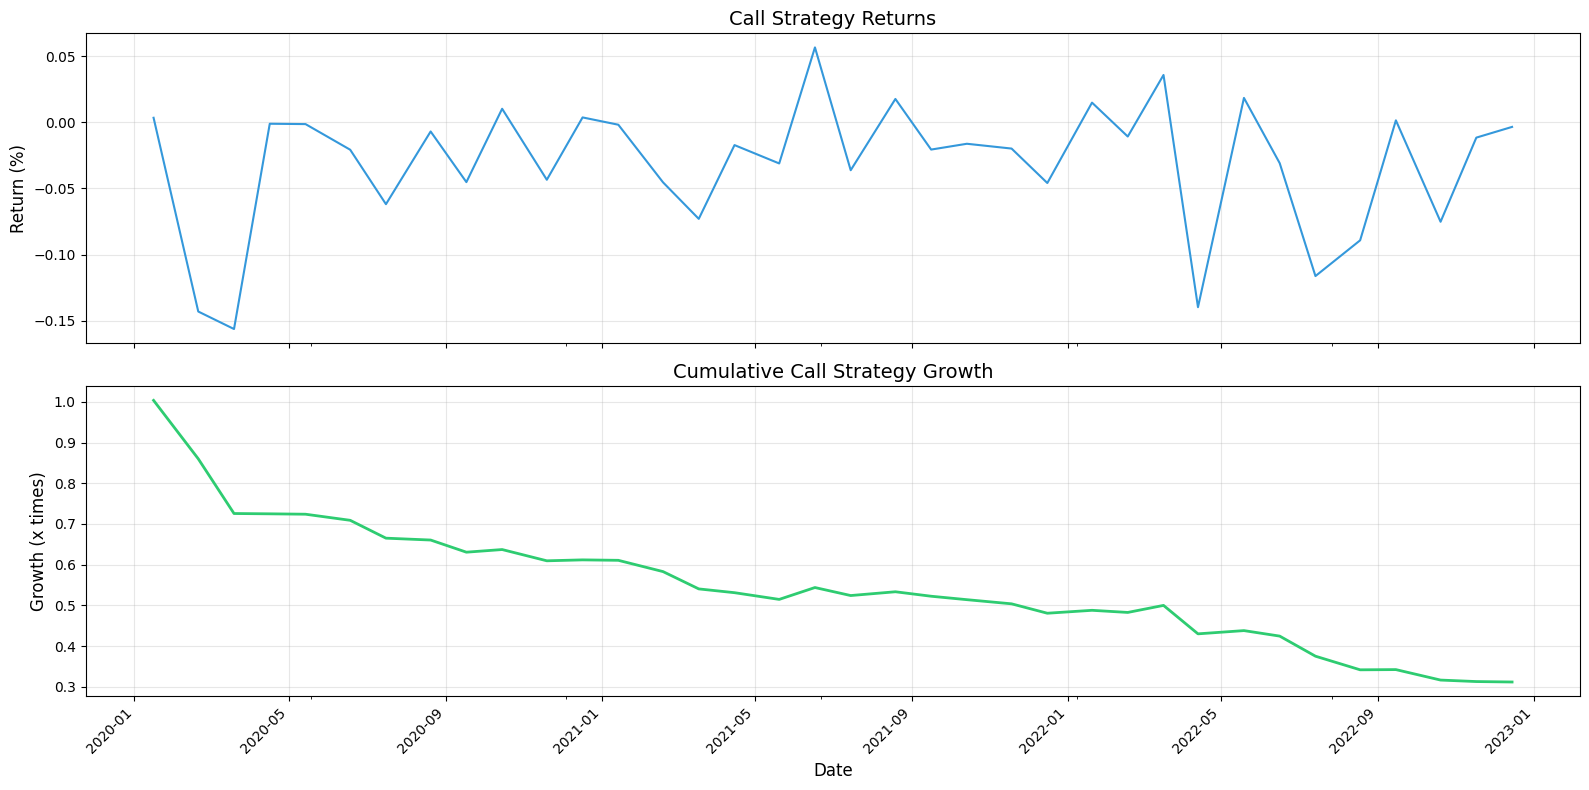

In [91]:
 ## Process the portfolio
import numpy as np

if __name__ == "__main__":
    # Process tickers
    tickers = ['BRK','MSFT', 'AAPL', 'AMZN', 'NVDA', 'WMT', 'LLY']
    results = process_multiple_tickers(tickers, cutoff_date=pd.Timestamp("2020-01-01"), 
                                       start_date='2015-01-01', end_date='2022-12-31')
    
    # Create call-only portfolio
    call_portfolio = create_call_portfolio(results)
    
    # Performance statistics
    print("Call Strategy Portfolio Summary:")
    print(f"Average Return: {call_portfolio['avg_call_return'].mean():.2%}")
    print(f"Volatility (Std Dev): {call_portfolio['avg_call_return'].std():.2%}")
    
    # Annualized Sharpe Ratio (assuming 252 trading days/year)
    annualized_sharpe = (call_portfolio['avg_call_return'].mean() / call_portfolio['avg_call_return'].std()) * np.sqrt(12)
    print(f"Sharpe Ratio (Annualized): {annualized_sharpe:.2f}")
    
    print(f"Final Portfolio Value: {call_portfolio['call_cumulative'].iloc[-1]:.2f}x")
    print(f"Maximum Drawdown: {(1 - call_portfolio['call_cumulative']/call_portfolio['call_cumulative'].cummax()).min():.2%}")
    
    # Plot results
    plot_call_portfolio(call_portfolio)

## Benchmark and beta test ##

### Out of sample test ###

Error processing BRK: Missing required columns: {'impl_volatility'}
Call Strategy Portfolio Summary:
Average Return: -3.06%
Volatility (Std Dev): 4.95%
Final Portfolio Value: 0.31x
Maximum Drawdown: 0.00%


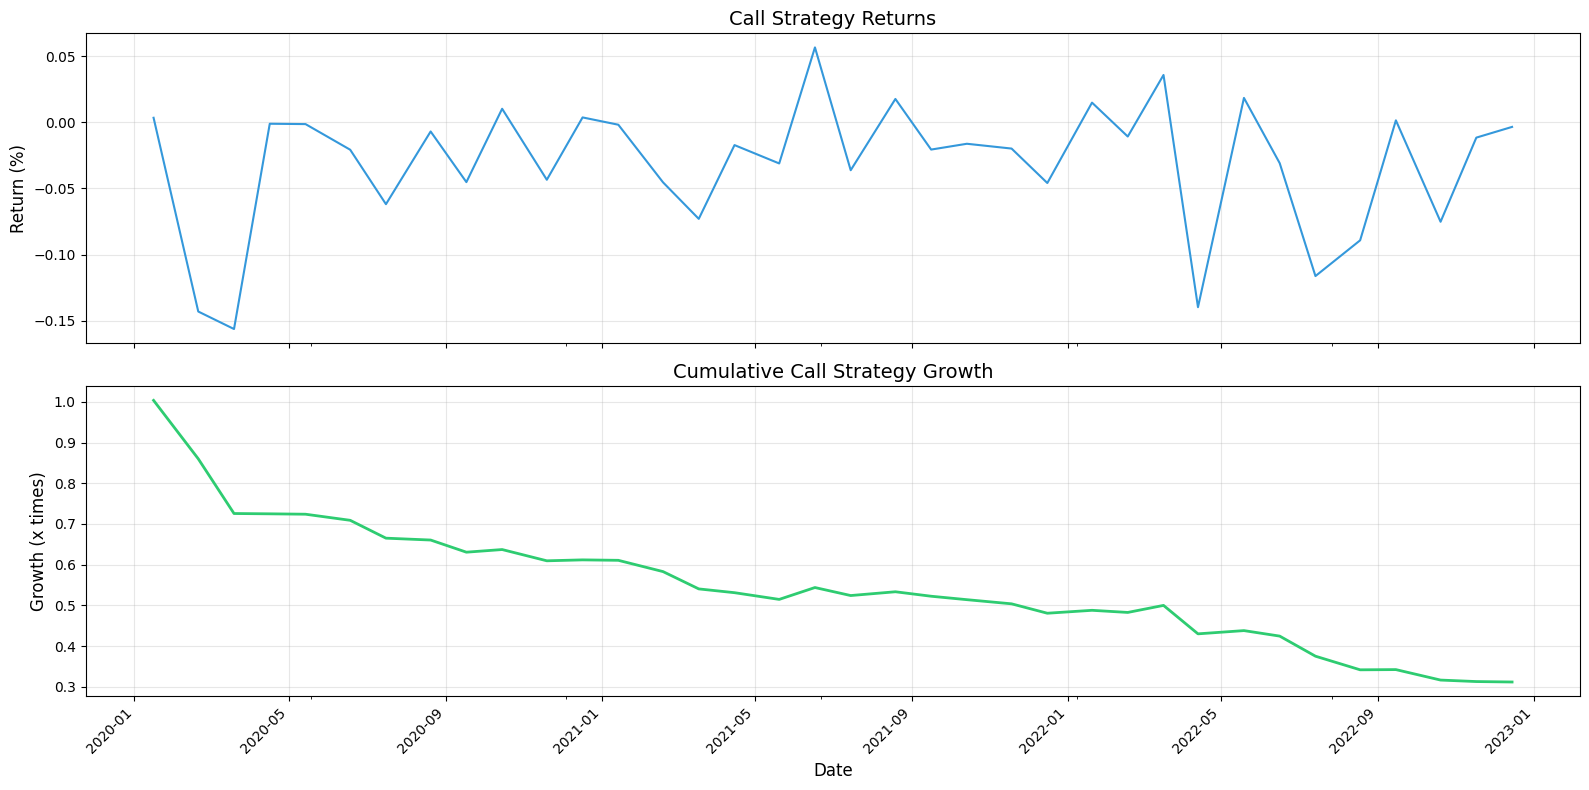

Call Strategy Portfolio Summary:
Average Return: -3.06%
Volatility (Std Dev): 4.95%
Final Portfolio Value: 0.31x
Maximum Drawdown: 0.00%


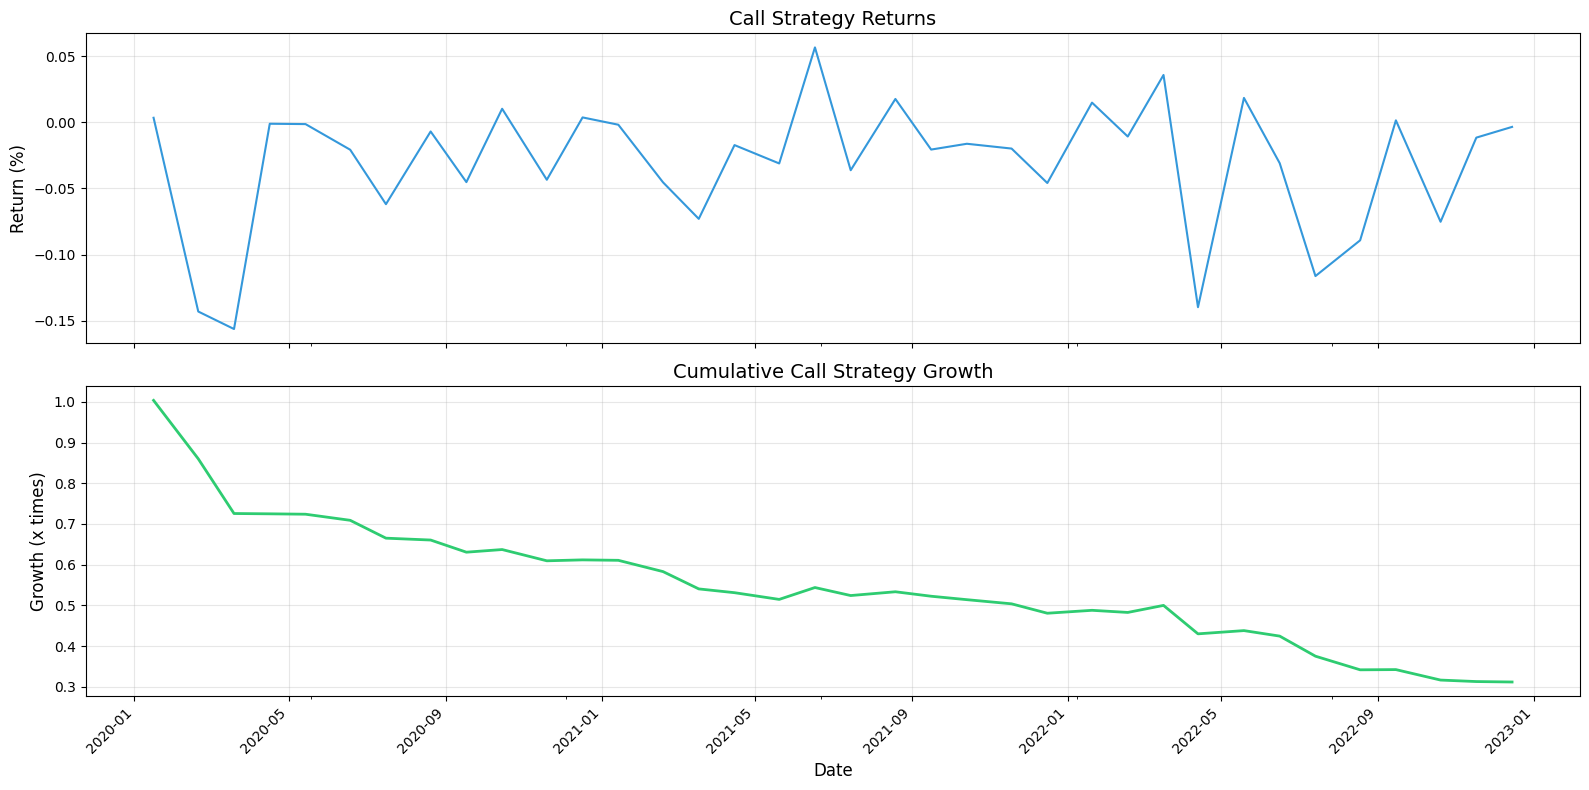

In [93]:
 # Process the portfolio with out of sample data (from 2023 onwards)
if __name__ == "__main__":
    # Process tickers
    tickers = ['BRK','MSFT', 'AAPL', 'AMZN', 'NVDA', 'WMT', 'LLY']
    results = process_multiple_tickers(tickers,cutoff_date=Timestamp("2020-01-01"),start_date='2015-01-01',
        end_date='2022-12-30')
    
    # Create call-only portfolio
    call_portfolio = create_call_portfolio(results)
    
    # Performance statistics
    print("Call Strategy Portfolio Summary:")
    print(f"Average Return: {call_portfolio['avg_call_return'].mean():.2%}")
    print(f"Volatility (Std Dev): {call_portfolio['avg_call_return'].std():.2%}")
    print(f"Final Portfolio Value: {call_portfolio['call_cumulative'].iloc[-1]:.2f}x")
    print(f"Maximum Drawdown: {(1 - call_portfolio['call_cumulative']/call_portfolio['call_cumulative'].cummax()).min():.2%}")
    
    # Plot results
    plot_call_portfolio(call_portfolio)

    
    # Performance statistics
print("Call Strategy Portfolio Summary:")
print(f"Average Return: {call_portfolio['avg_call_return'].mean():.2%}")
print(f"Volatility (Std Dev): {call_portfolio['avg_call_return'].std():.2%}")
print(f"Final Portfolio Value: {call_portfolio['call_cumulative'].iloc[-1]:.2f}x")
print(f"Maximum Drawdown: {(1 - call_portfolio['call_cumulative']/call_portfolio['call_cumulative'].cummax()).min():.2%}")
    
    # Plot results
plot_call_portfolio(call_portfolio)

### Compare with market performance ### (beta test)

In [94]:
## FF3

import pandas as pd
import pandas_datareader.data as web
import statsmodels.api as sm

def get_ff3_factors(start, end):
    """
    Fetch the Fama-French 3 factors from the Kenneth French database.
    
    Parameters:
    start (str): Start date in 'YYYY-MM-DD' format.
    end (str): End date in 'YYYY-MM-DD' format.
    
    Returns:
    pd.DataFrame: DataFrame containing the FF3 factors (monthly data)
    """
    ff3 = web.DataReader("F-F_Research_Data_Factors", "famafrench", start, end)[0]
    ff3 = ff3[['SMB', 'HML', 'Mkt-RF']] / 100  # Convert to decimal format
    
    return ff3

def fama_french_3_factor_test(portfolio_returns):
    start = portfolio_returns.index.min().strftime('%Y-%m-%d')
    end = portfolio_returns.index.max().strftime('%Y-%m-%d')

    # Get Fama-French factors
    ff3_factors = get_ff3_factors(start, end)
    #display(ff3_factors)

    # Merge portfolio returns with Fama-French factors
    portfolio_returns.index = portfolio_returns.index.to_period('M')
    data = portfolio_returns.merge(ff3_factors, left_index=True, right_index=True, how='inner')
    #display(data)
    data.columns = ['avg_call_return' , 'call_cumulative', 'smb', 'hml', 'mkt']
    
    # Estimate OLS regression model
    model = smf.ols(formula='avg_call_return ~ mkt + smb + hml', data=data).fit()
    return model

# Usage example
if __name__ == "__main__":
    # First create portfolio (assuming results_dict exists)
    portfolio = create_call_portfolio(results)
    #display(portfolio)
    # Run FF3 test
    ff3_results = fama_french_3_factor_test(portfolio)
    print(ff3_results.summary())

C:\Users\Dang Huy\AppData\Local\Temp\ipykernel_492416\190786412.py:18: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff3 = web.DataReader("F-F_Research_Data_Factors", "famafrench", start, end)[0]
C:\Users\Dang Huy\AppData\Local\Temp\ipykernel_492416\190786412.py:18: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff3 = web.DataReader("F-F_Research_Data_Factors", "famafrench", start, end)[0]


                            OLS Regression Results                            
Dep. Variable:        avg_call_return   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.007
Date:                Sun, 23 Mar 2025   Prob (F-statistic):              0.402
Time:                        23:43:08   Log-Likelihood:                 59.224
No. Observations:                  36   AIC:                            -110.4
Df Residuals:                      32   BIC:                            -104.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0325      0.008     -3.900      0.0

## Conclusion ##
In the end we can say that our strategy is underperforming the respective stock due to some aggressive outliers which draw down our return massively. So in the end our strategy made an average return of  minus 3% per month.
Regarding our regression statistics where we tried to find any relationships between our strategy returns and market returns. Here we could not find any strong relationships. This means that our strategy might be very uncorrelated with the stock market. What is good from a diversification perspective, as our strategy can help to strengthen the sharpe ratio of a portfolio.
There is still room to improve our strategy by running better prediction models, for example we can do a rolling window volatility adjustment or even try to run volatility prediction models like ARCH or GARCH models.